In [1]:
import pandas as pd
import vcfpy
from SigProfilerAssignment import Analyzer as Analyze
import musical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import shutil
import ast
from tqdm import tqdm 
import re
from io import StringIO
import math
%matplotlib inline

## Create a directory with all clonal indels (HRD WGD PCAWG)

In [ ]:
timing_data = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")
sample_ids = timing_data[timing_data['cohort'] == 'PCAWG']['ID'].tolist()

input_dir = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/PCAWG_Indels/vcfs"
output_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels"
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(input_dir):
    if file.endswith(".vcf"):
        sample_id = file.replace(".vcf", "")
        if sample_id in sample_ids:
            with open(os.path.join(input_dir, file)) as f:
                lines = f.readlines()
            header = [l for l in lines if l.startswith('##')]
            chrom_line = next(l for l in lines if l.startswith('#CHROM'))
            data_lines = [l for l in lines if not l.startswith('##')]
            df = pd.read_csv(StringIO(''.join(data_lines)), sep='\t')
            clonal = df[df['INFO'].str.contains(r'CLS=clonal\b', na=False)]
            if not clonal.empty:
                with open(os.path.join(output_dir, file), 'w') as out_f:
                    clonal.to_csv(out_f, sep='\t', index=False)

## Create a directory with all clonal SNvs (HRD WGD PCAWG)

In [24]:
timing_data = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")
sample_ids = timing_data[timing_data['cohort'] == 'PCAWG']['ID'].tolist()

input_dir = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/PCAWG/hrdtimer_results_v3"
output_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_SNVs"
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(input_dir):
    if file.endswith(".vcf"):
        sample_id = file.replace(".vcf", "")
        if sample_id in sample_ids:
            with open(os.path.join(input_dir, file)) as f:
                lines = f.readlines()
            header = [l for l in lines if l.startswith('##')]
            chrom_line = next(l for l in lines if l.startswith('#CHROM'))
            data_lines = [l for l in lines if not l.startswith('##')]
            df = pd.read_csv(StringIO(''.join(data_lines)), sep='\t')
            clonal = df[df['INFO'].str.contains(r'CLS=clonal\b', na=False)]
            if not clonal.empty:
                with open(os.path.join(output_dir, file), 'w') as out_f:
                    clonal.to_csv(out_f, sep='\t', index=False)


## Compare SNV ID VAF distributions

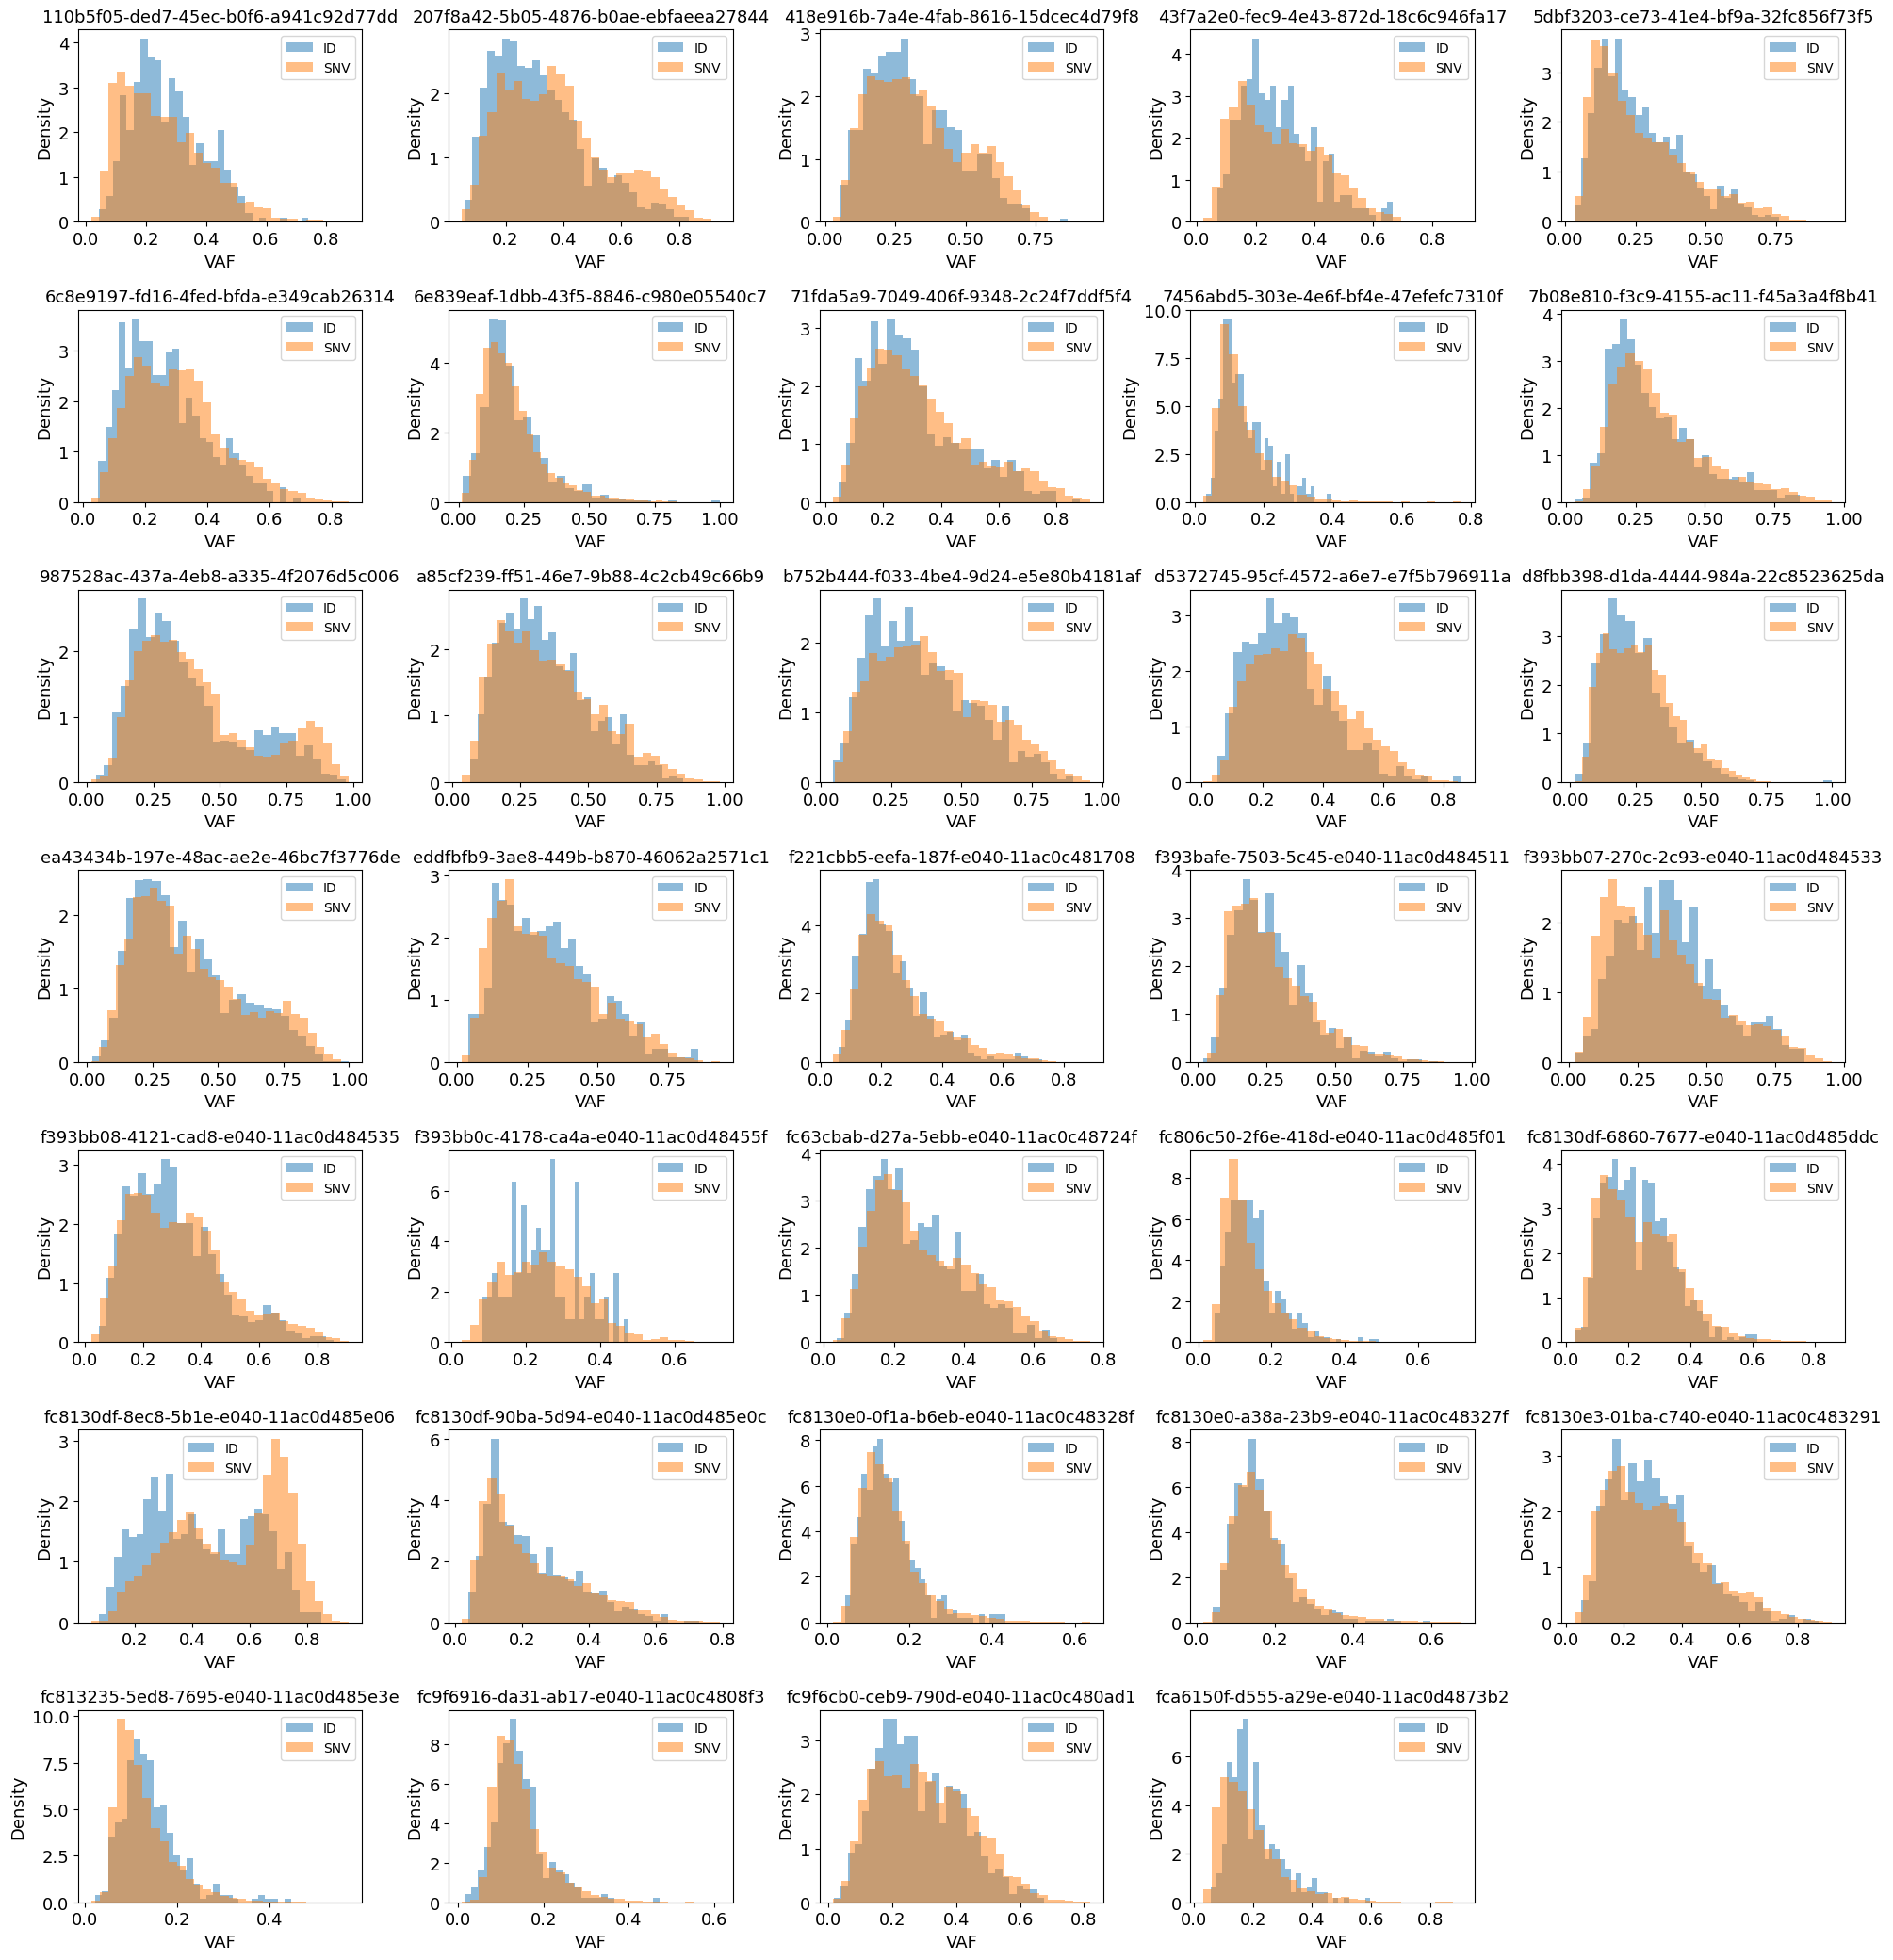

In [27]:
indel_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels"
snv_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_SNVs"

def extract_vaf(info):
    match = re.search(r'VAF=([\d.]+)', info)
    return float(match.group(1)) if match else None

indel_data = {}
for file in os.listdir(indel_dir):
    if file.endswith('.vcf'):
        df = pd.read_csv(os.path.join(indel_dir, file), sep='\t')
        vafs = df['INFO'].apply(extract_vaf).dropna()
        if not vafs.empty:
            indel_data[file.replace('.vcf', '')] = vafs

snv_data = {}
for file in os.listdir(snv_dir):
    if file.endswith('.vcf'):
        df = pd.read_csv(os.path.join(snv_dir, file), sep='\t')
        vafs = df['INFO'].apply(extract_vaf).dropna()
        if not vafs.empty:
            snv_data[file.replace('.vcf', '')] = vafs

samples = sorted(set(indel_data) | set(snv_data))
n_samples = len(samples)
n_cols = 5
n_rows = math.ceil(n_samples / n_cols)

plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

for i, sample in enumerate(samples):
    ax = axes[i]
    if sample in indel_data:
        ax.hist(indel_data[sample], bins=30, alpha=0.5, label='ID', color='tab:blue', density=True)
    if sample in snv_data:
        ax.hist(snv_data[sample], bins=30, alpha=0.5, label='SNV', color='tab:orange', density=True)
    ax.set_title(sample, fontsize=13)
    ax.set_xlabel('VAF')
    ax.set_ylabel('Density')
    ax.legend(fontsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


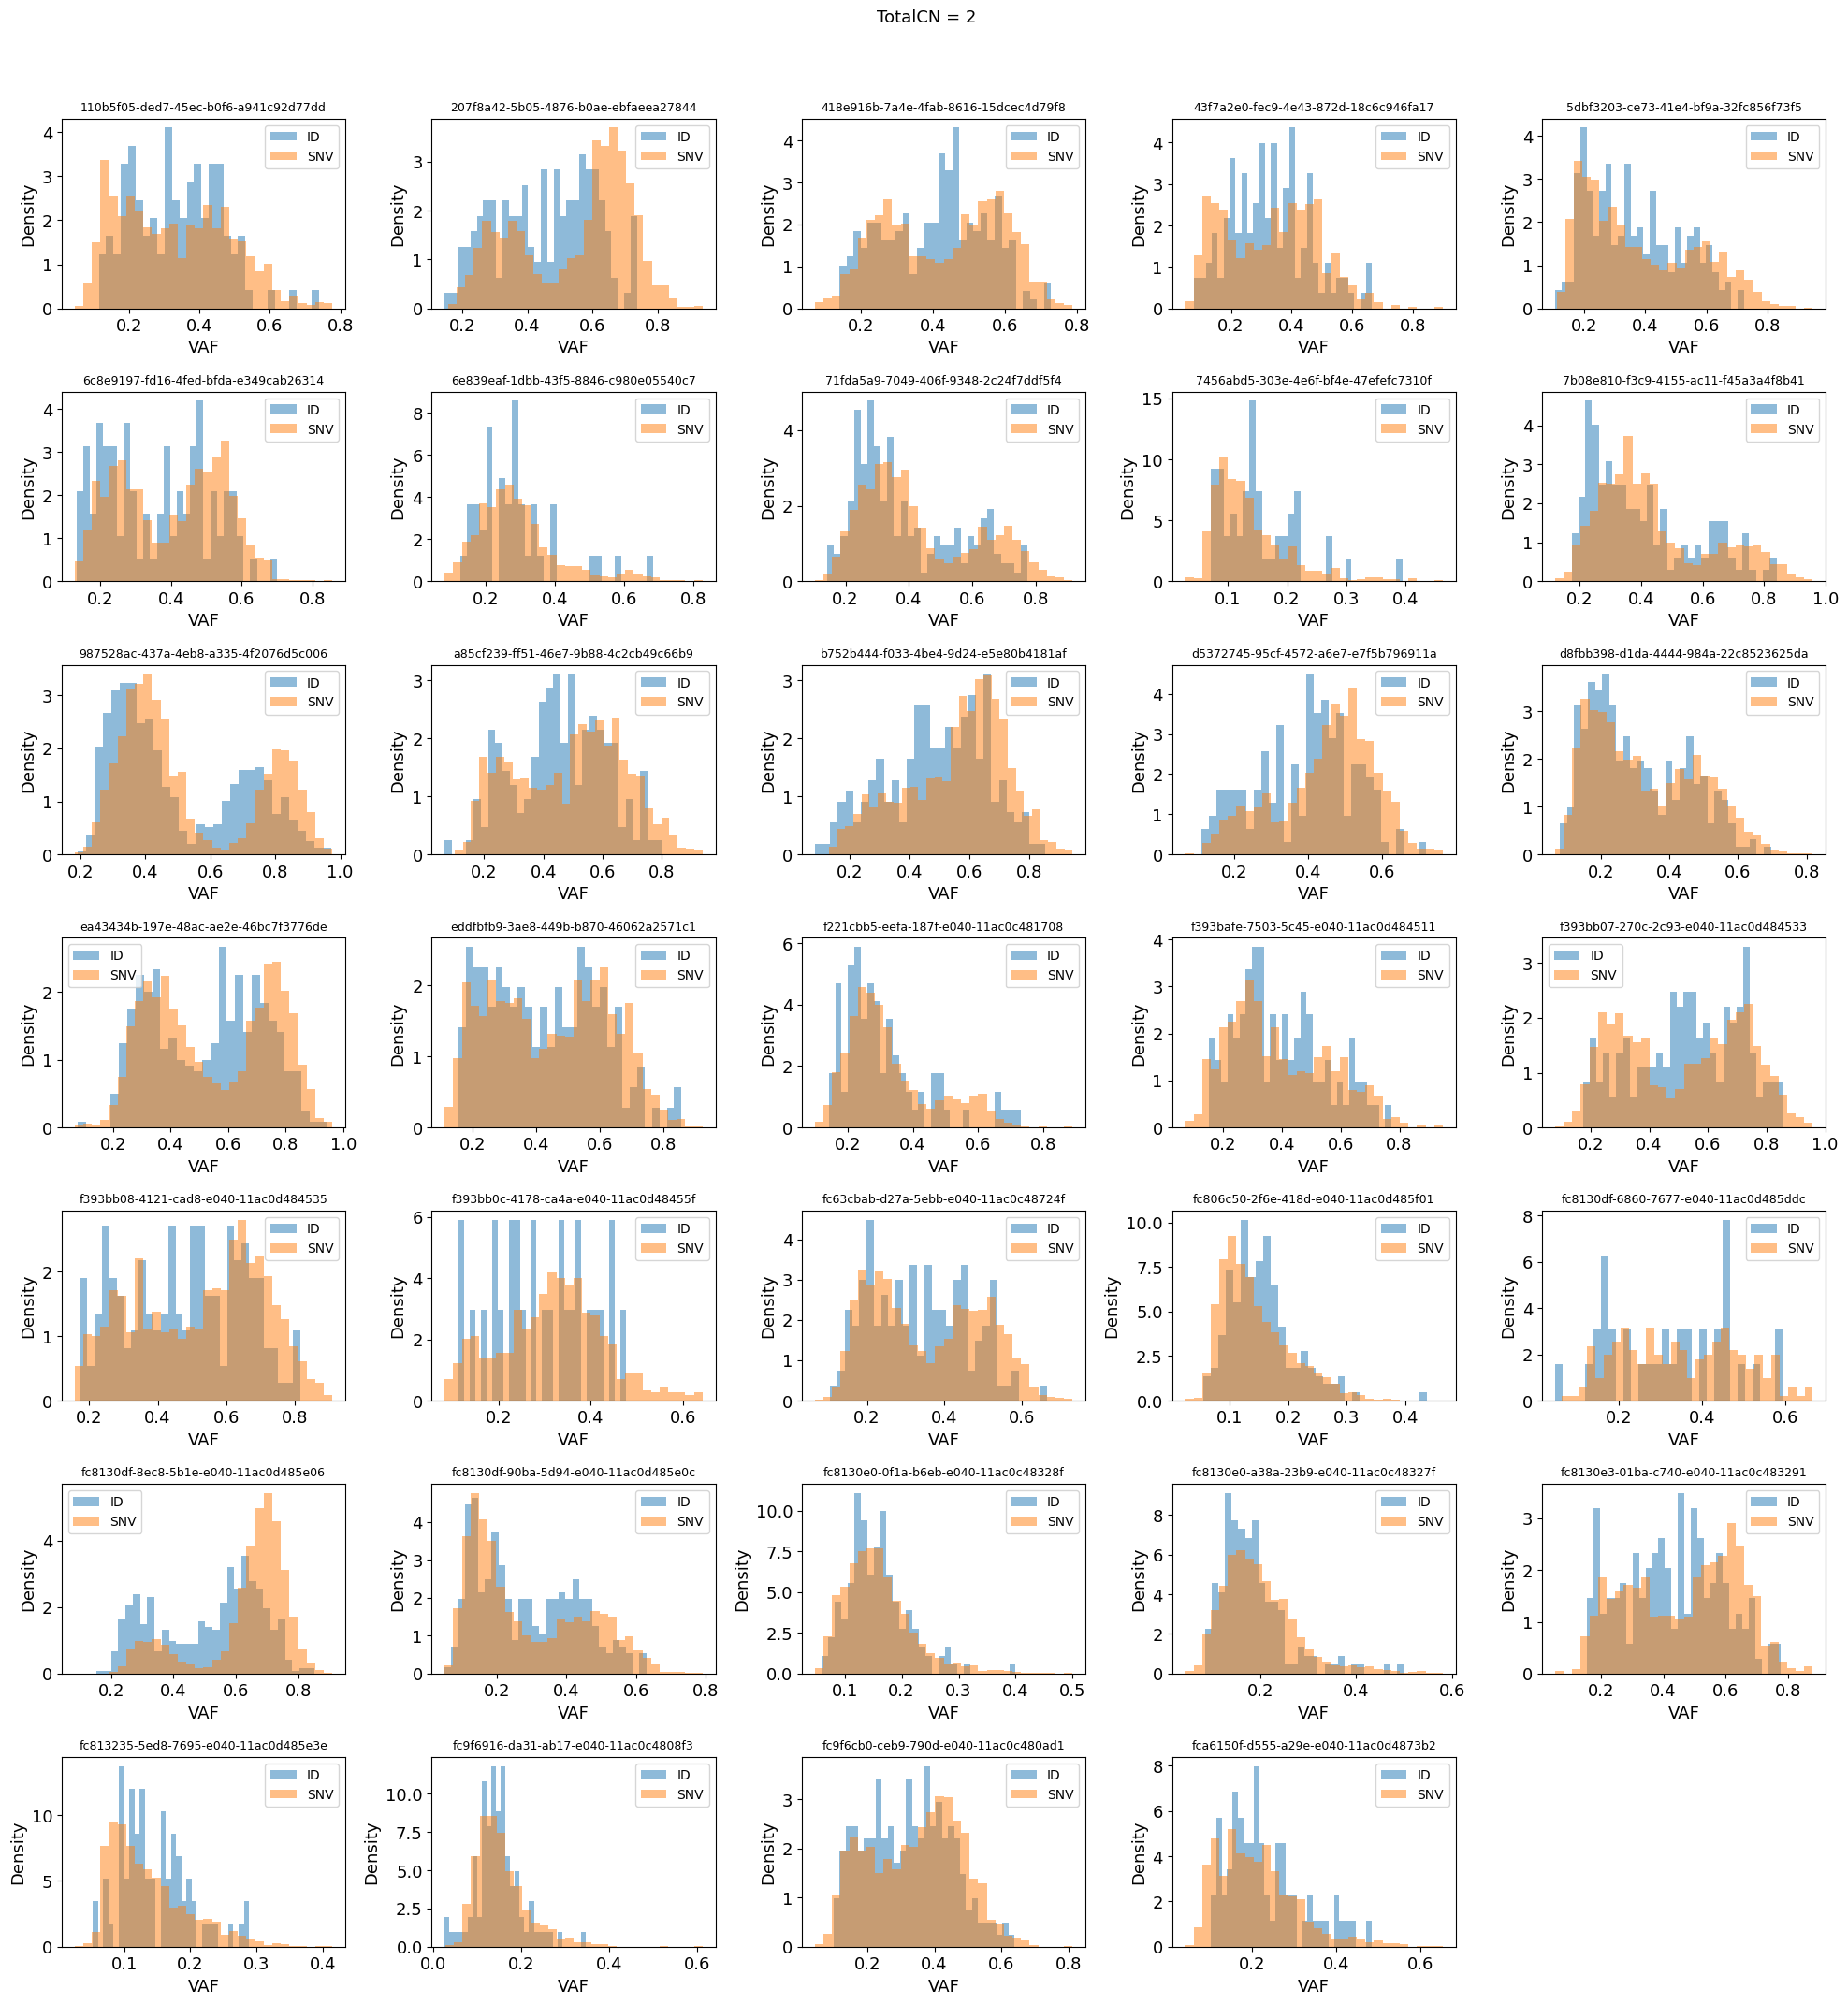

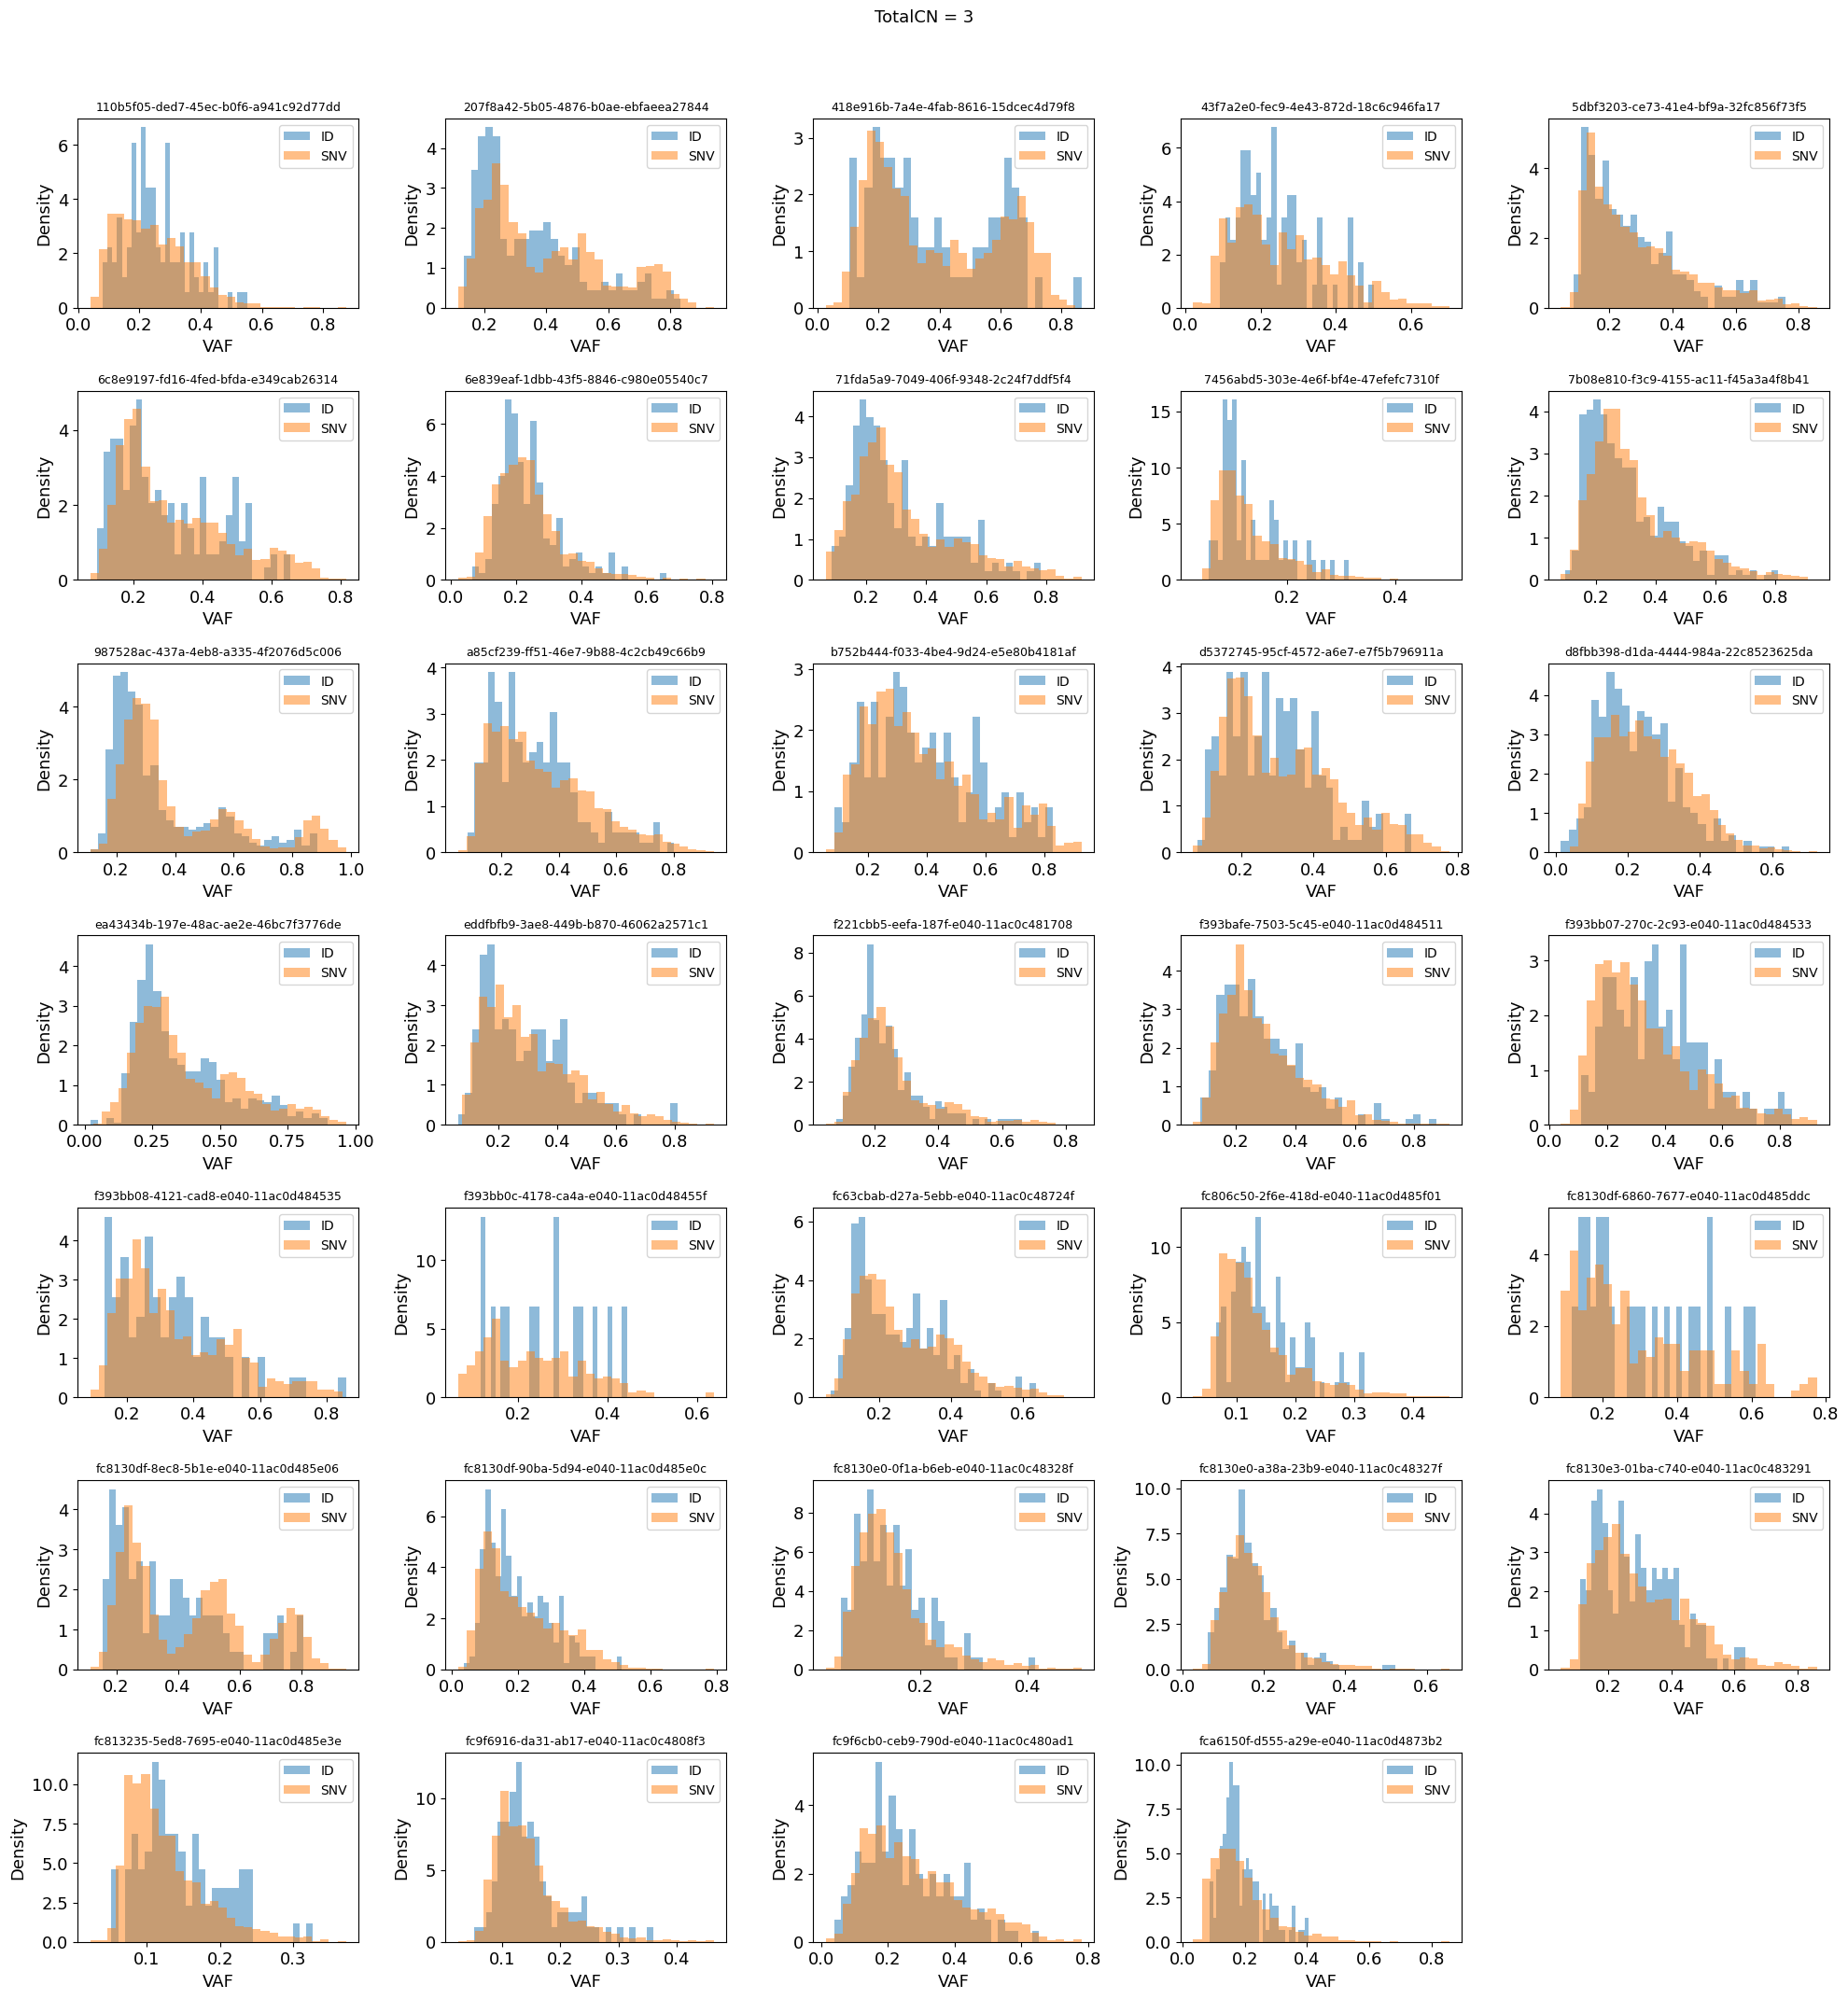

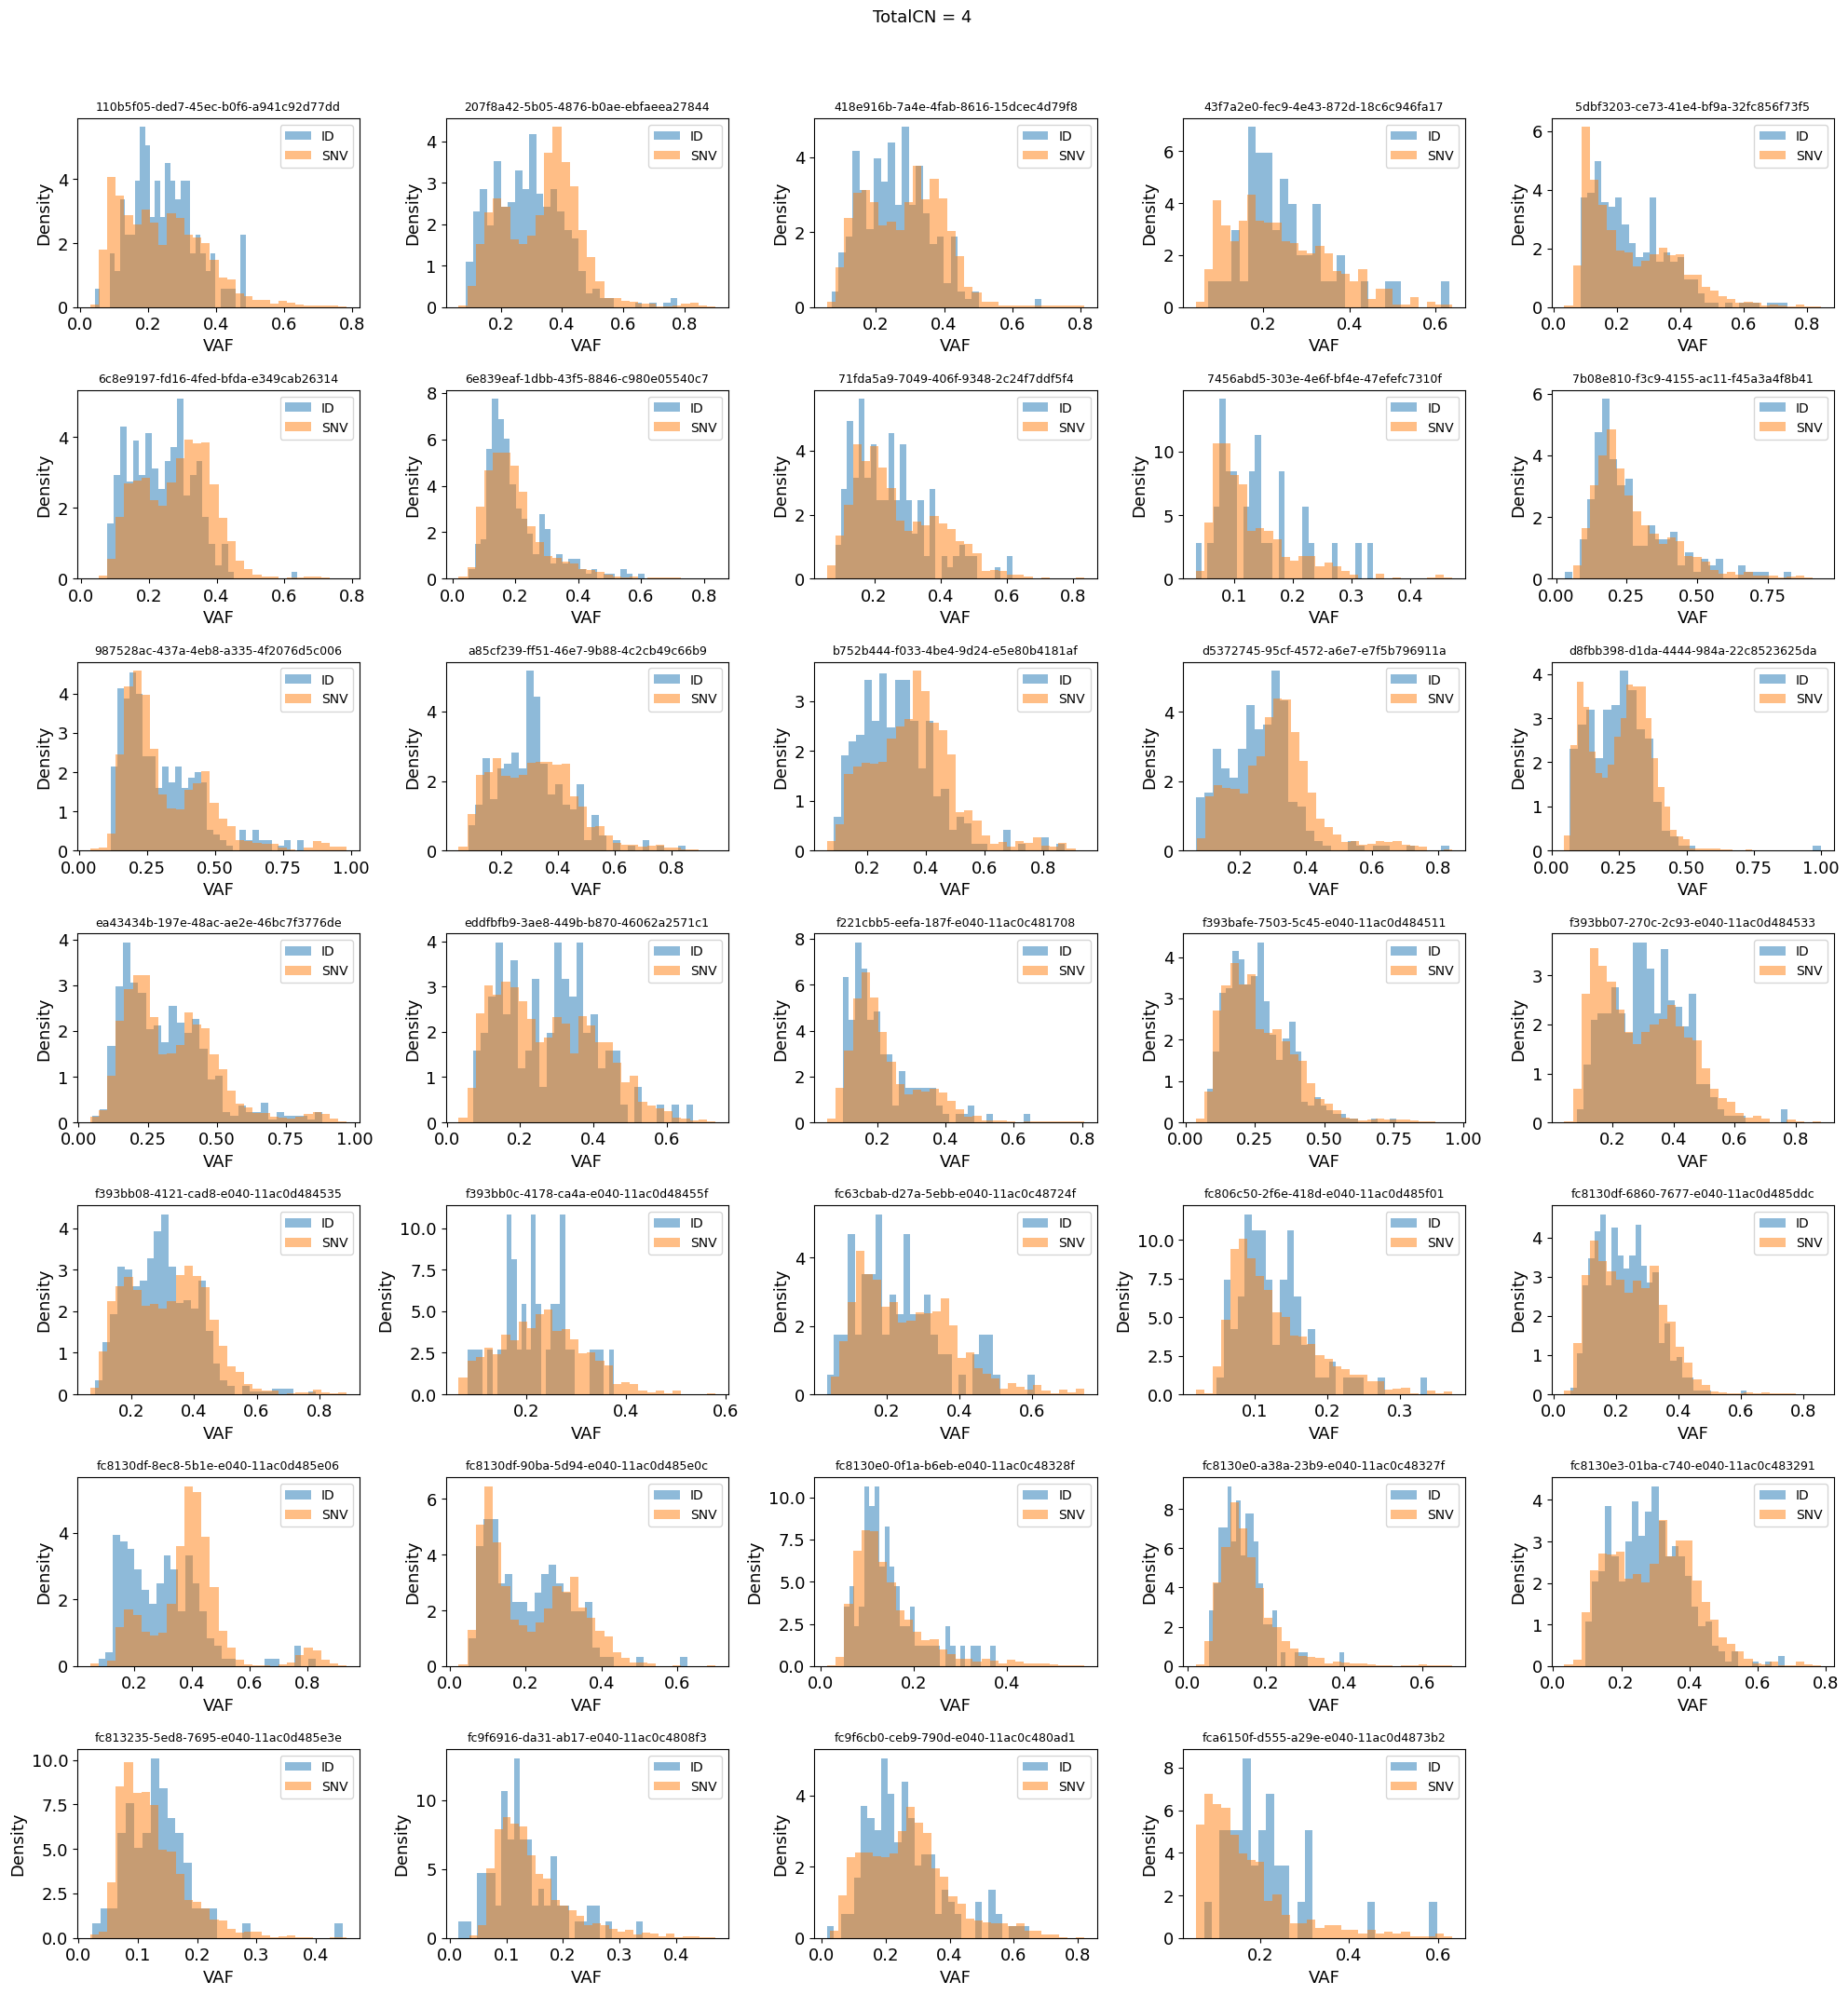

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import math

indel_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels"
snv_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_SNVs"

def extract_vaf_and_total_cn(info):
    vaf_match = re.search(r'VAF=([\d.]+)', info)
    mincn_match = re.search(r'MinCN=(\d+)', info)
    majcn_match = re.search(r'MajCN=(\d+)', info)
    
    vaf = float(vaf_match.group(1)) if vaf_match else None
    mincn = int(mincn_match.group(1)) if mincn_match else None
    majcn = int(majcn_match.group(1)) if majcn_match else None
    
    total_cn = (mincn + majcn) if (mincn is not None and majcn is not None) else None
    return vaf, total_cn

def collect_data(folder):
    data = {2: {}, 3: {}, 4: {}}
    for file in os.listdir(folder):
        if file.endswith('.vcf'):
            df = pd.read_csv(os.path.join(folder, file), sep='\t')
            sample_id = file.replace('.vcf', '')
            
            for total_cn in [2, 3, 4]:
                vafs = df['INFO'].apply(lambda x: extract_vaf_and_total_cn(x)) \
                                  .dropna().tolist()
                vafs_for_cn = [v for v, cn in vafs if cn == total_cn and v is not None]
                
                if vafs_for_cn:
                    data[total_cn].setdefault(sample_id, []).extend(vafs_for_cn)
    return data

indel_data = collect_data(indel_dir)
snv_data = collect_data(snv_dir)

for total_cn in [2, 3, 4]:
    samples = sorted(set(indel_data[total_cn]) | set(snv_data[total_cn]))
    n_samples = len(samples)
    n_cols = 5
    n_rows = math.ceil(n_samples / n_cols)
    
    plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()
    
    for i, sample in enumerate(samples):
        ax = axes[i]
        if sample in indel_data[total_cn]:
            ax.hist(indel_data[total_cn][sample], bins=30, alpha=0.5, label='ID', color='tab:blue', density=True)
        if sample in snv_data[total_cn]:
            ax.hist(snv_data[total_cn][sample], bins=30, alpha=0.5, label='SNV', color='tab:orange', density=True)
        ax.set_title(f"{sample}", fontsize=9)
        ax.set_xlabel('VAF')
        ax.set_ylabel('Density')
        ax.legend(fontsize=10)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(f"TotalCN = {total_cn}", fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()


['110b5f05-ded7-45ec-b0f6-a941c92d77dd', '207f8a42-5b05-4876-b0ae-ebfaeea27844', '418e916b-7a4e-4fab-8616-15dcec4d79f8', '43f7a2e0-fec9-4e43-872d-18c6c946fa17', '5dbf3203-ce73-41e4-bf9a-32fc856f73f5', '6c8e9197-fd16-4fed-bfda-e349cab26314', '6e839eaf-1dbb-43f5-8846-c980e05540c7', '71fda5a9-7049-406f-9348-2c24f7ddf5f4', '7456abd5-303e-4e6f-bf4e-47efefc7310f', '7b08e810-f3c9-4155-ac11-f45a3a4f8b41', '987528ac-437a-4eb8-a335-4f2076d5c006', 'a85cf239-ff51-46e7-9b88-4c2cb49c66b9', 'b752b444-f033-4be4-9d24-e5e80b4181af', 'd5372745-95cf-4572-a6e7-e7f5b796911a', 'd8fbb398-d1da-4444-984a-22c8523625da', 'ea43434b-197e-48ac-ae2e-46bc7f3776de', 'eddfbfb9-3ae8-449b-b870-46062a2571c1', 'f221cbb5-eefa-187f-e040-11ac0c481708', 'f393bafe-7503-5c45-e040-11ac0d484511', 'f393bb07-270c-2c93-e040-11ac0d484533', 'f393bb08-4121-cad8-e040-11ac0d484535', 'f393bb0c-4178-ca4a-e040-11ac0d48455f', 'fc63cbab-d27a-5ebb-e040-11ac0c48724f', 'fc806c50-2f6e-418d-e040-11ac0d485f01', 'fc8130df-6860-7677-e040-11ac0d485ddc',

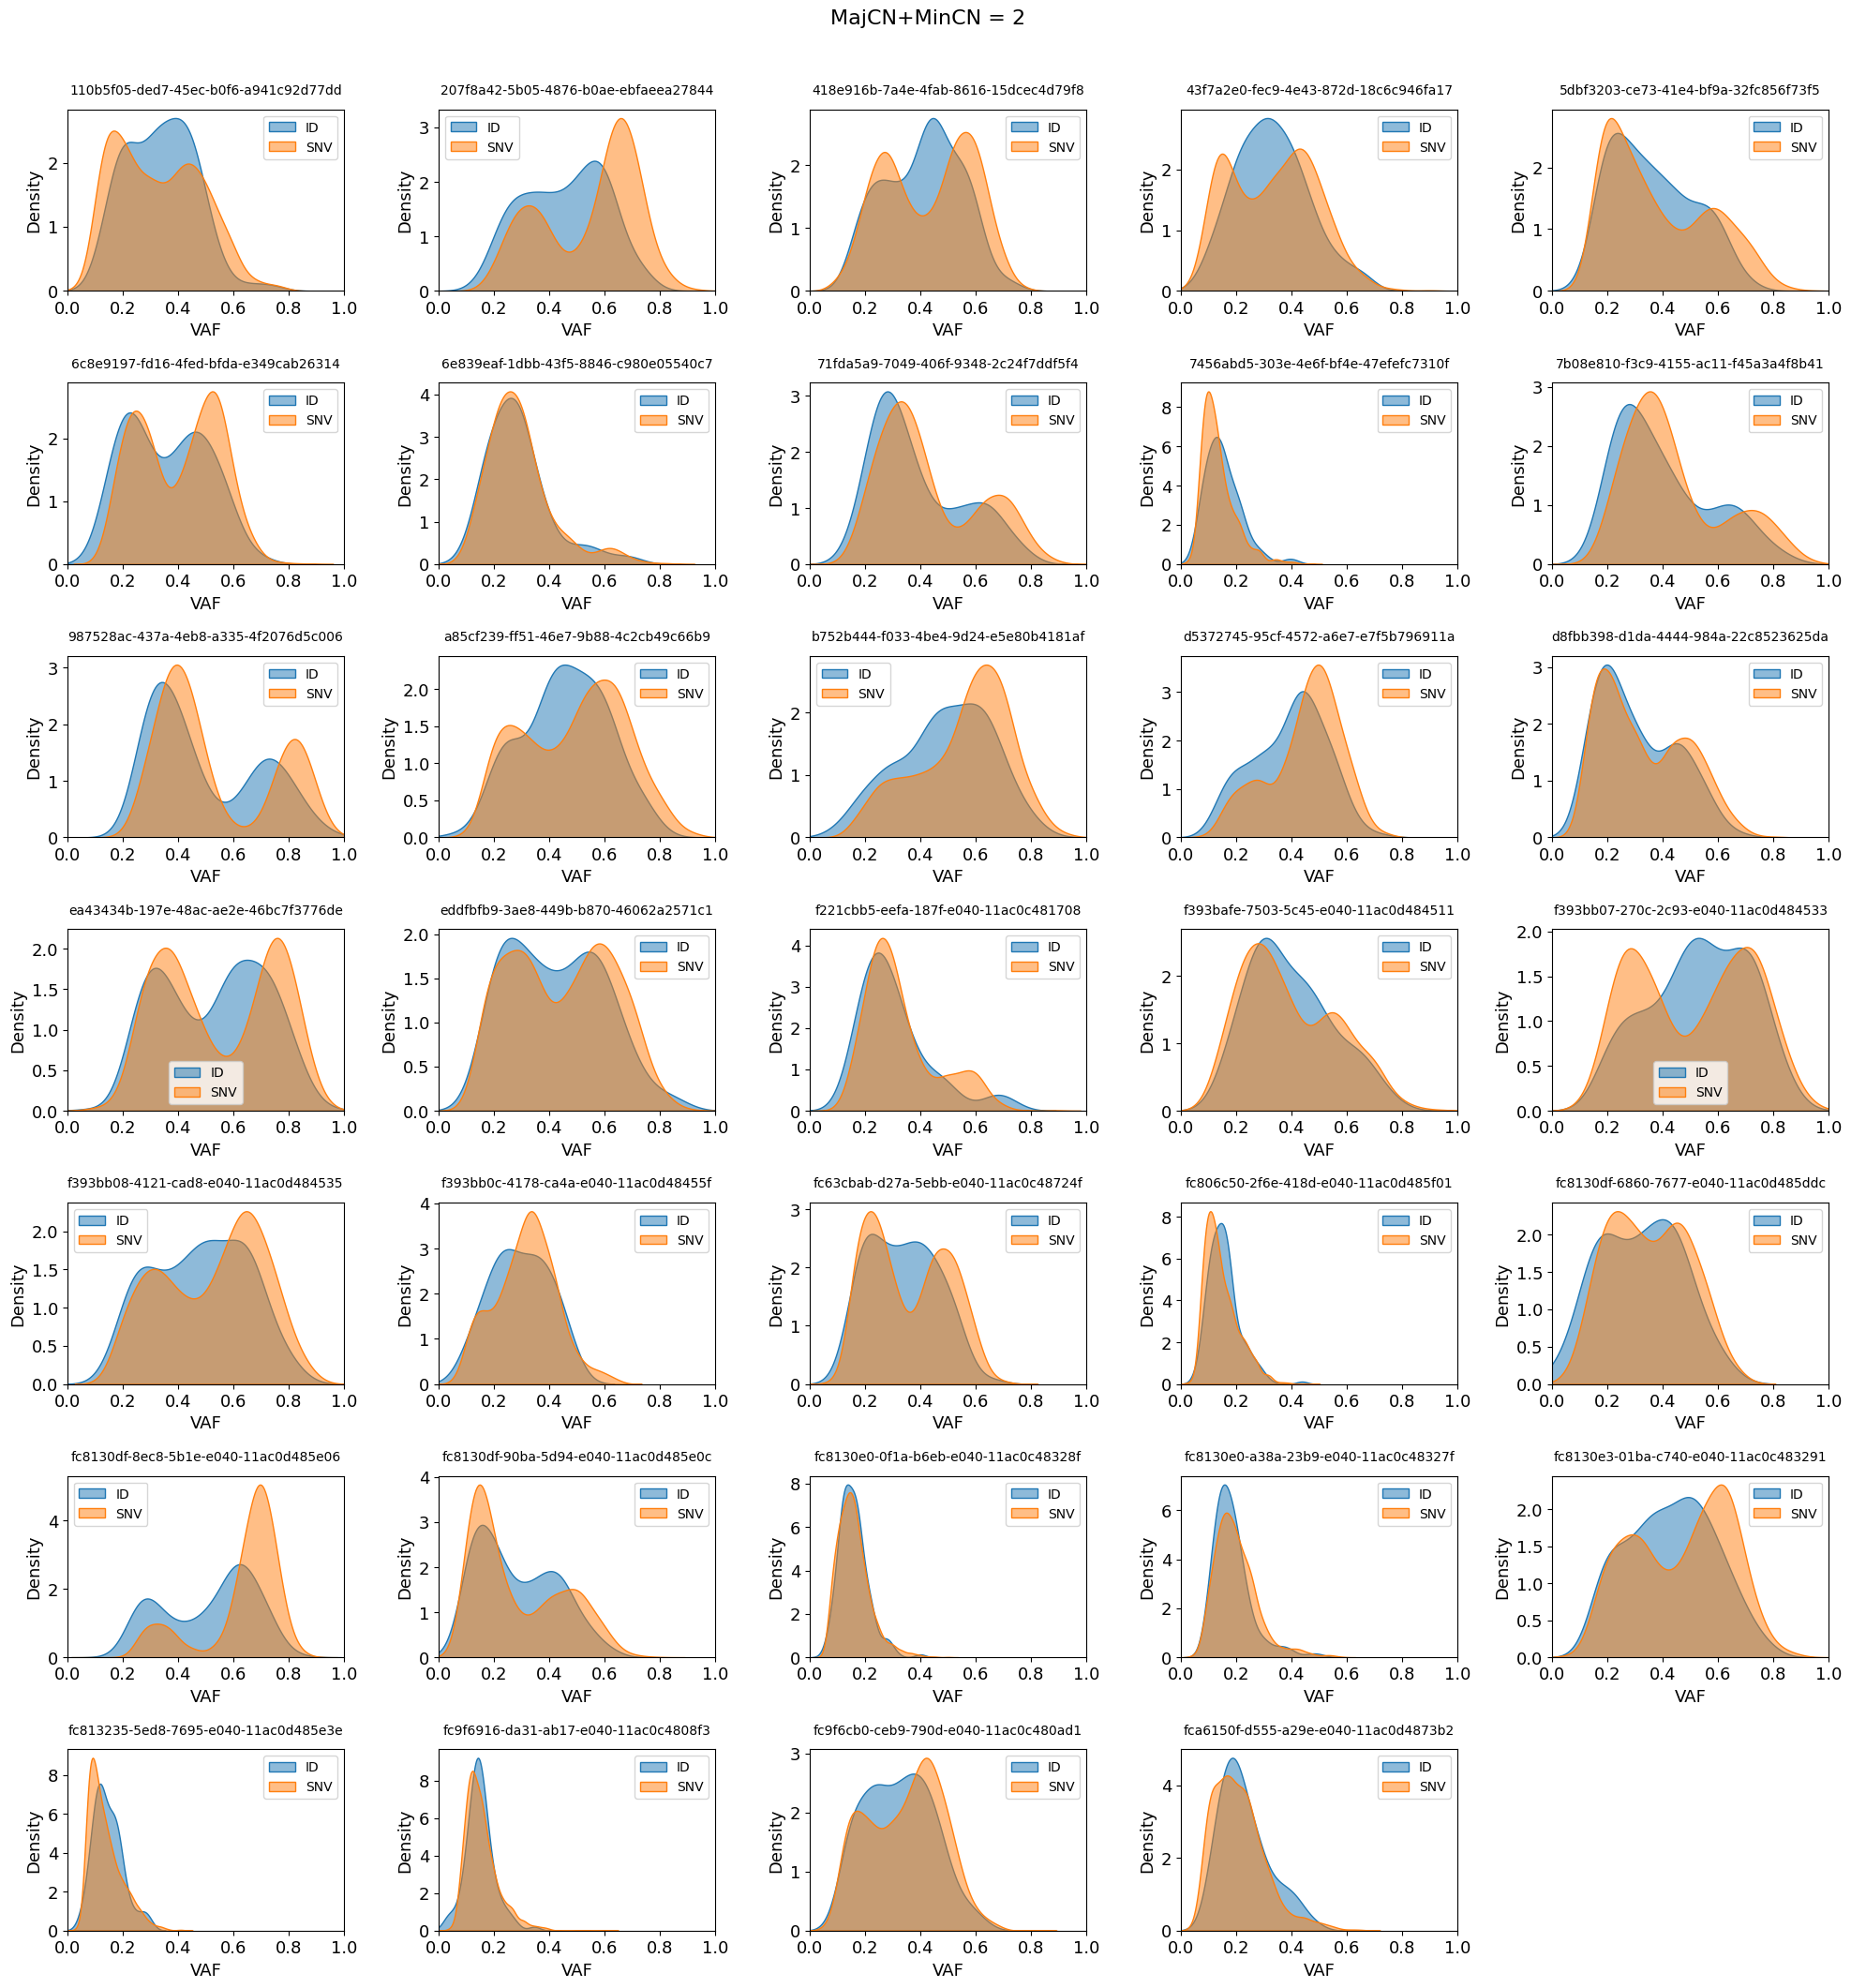

['110b5f05-ded7-45ec-b0f6-a941c92d77dd', '207f8a42-5b05-4876-b0ae-ebfaeea27844', '418e916b-7a4e-4fab-8616-15dcec4d79f8', '43f7a2e0-fec9-4e43-872d-18c6c946fa17', '5dbf3203-ce73-41e4-bf9a-32fc856f73f5', '6c8e9197-fd16-4fed-bfda-e349cab26314', '6e839eaf-1dbb-43f5-8846-c980e05540c7', '71fda5a9-7049-406f-9348-2c24f7ddf5f4', '7456abd5-303e-4e6f-bf4e-47efefc7310f', '7b08e810-f3c9-4155-ac11-f45a3a4f8b41', '987528ac-437a-4eb8-a335-4f2076d5c006', 'a85cf239-ff51-46e7-9b88-4c2cb49c66b9', 'b752b444-f033-4be4-9d24-e5e80b4181af', 'd5372745-95cf-4572-a6e7-e7f5b796911a', 'd8fbb398-d1da-4444-984a-22c8523625da', 'ea43434b-197e-48ac-ae2e-46bc7f3776de', 'eddfbfb9-3ae8-449b-b870-46062a2571c1', 'f221cbb5-eefa-187f-e040-11ac0c481708', 'f393bafe-7503-5c45-e040-11ac0d484511', 'f393bb07-270c-2c93-e040-11ac0d484533', 'f393bb08-4121-cad8-e040-11ac0d484535', 'f393bb0c-4178-ca4a-e040-11ac0d48455f', 'fc63cbab-d27a-5ebb-e040-11ac0c48724f', 'fc806c50-2f6e-418d-e040-11ac0d485f01', 'fc8130df-6860-7677-e040-11ac0d485ddc',

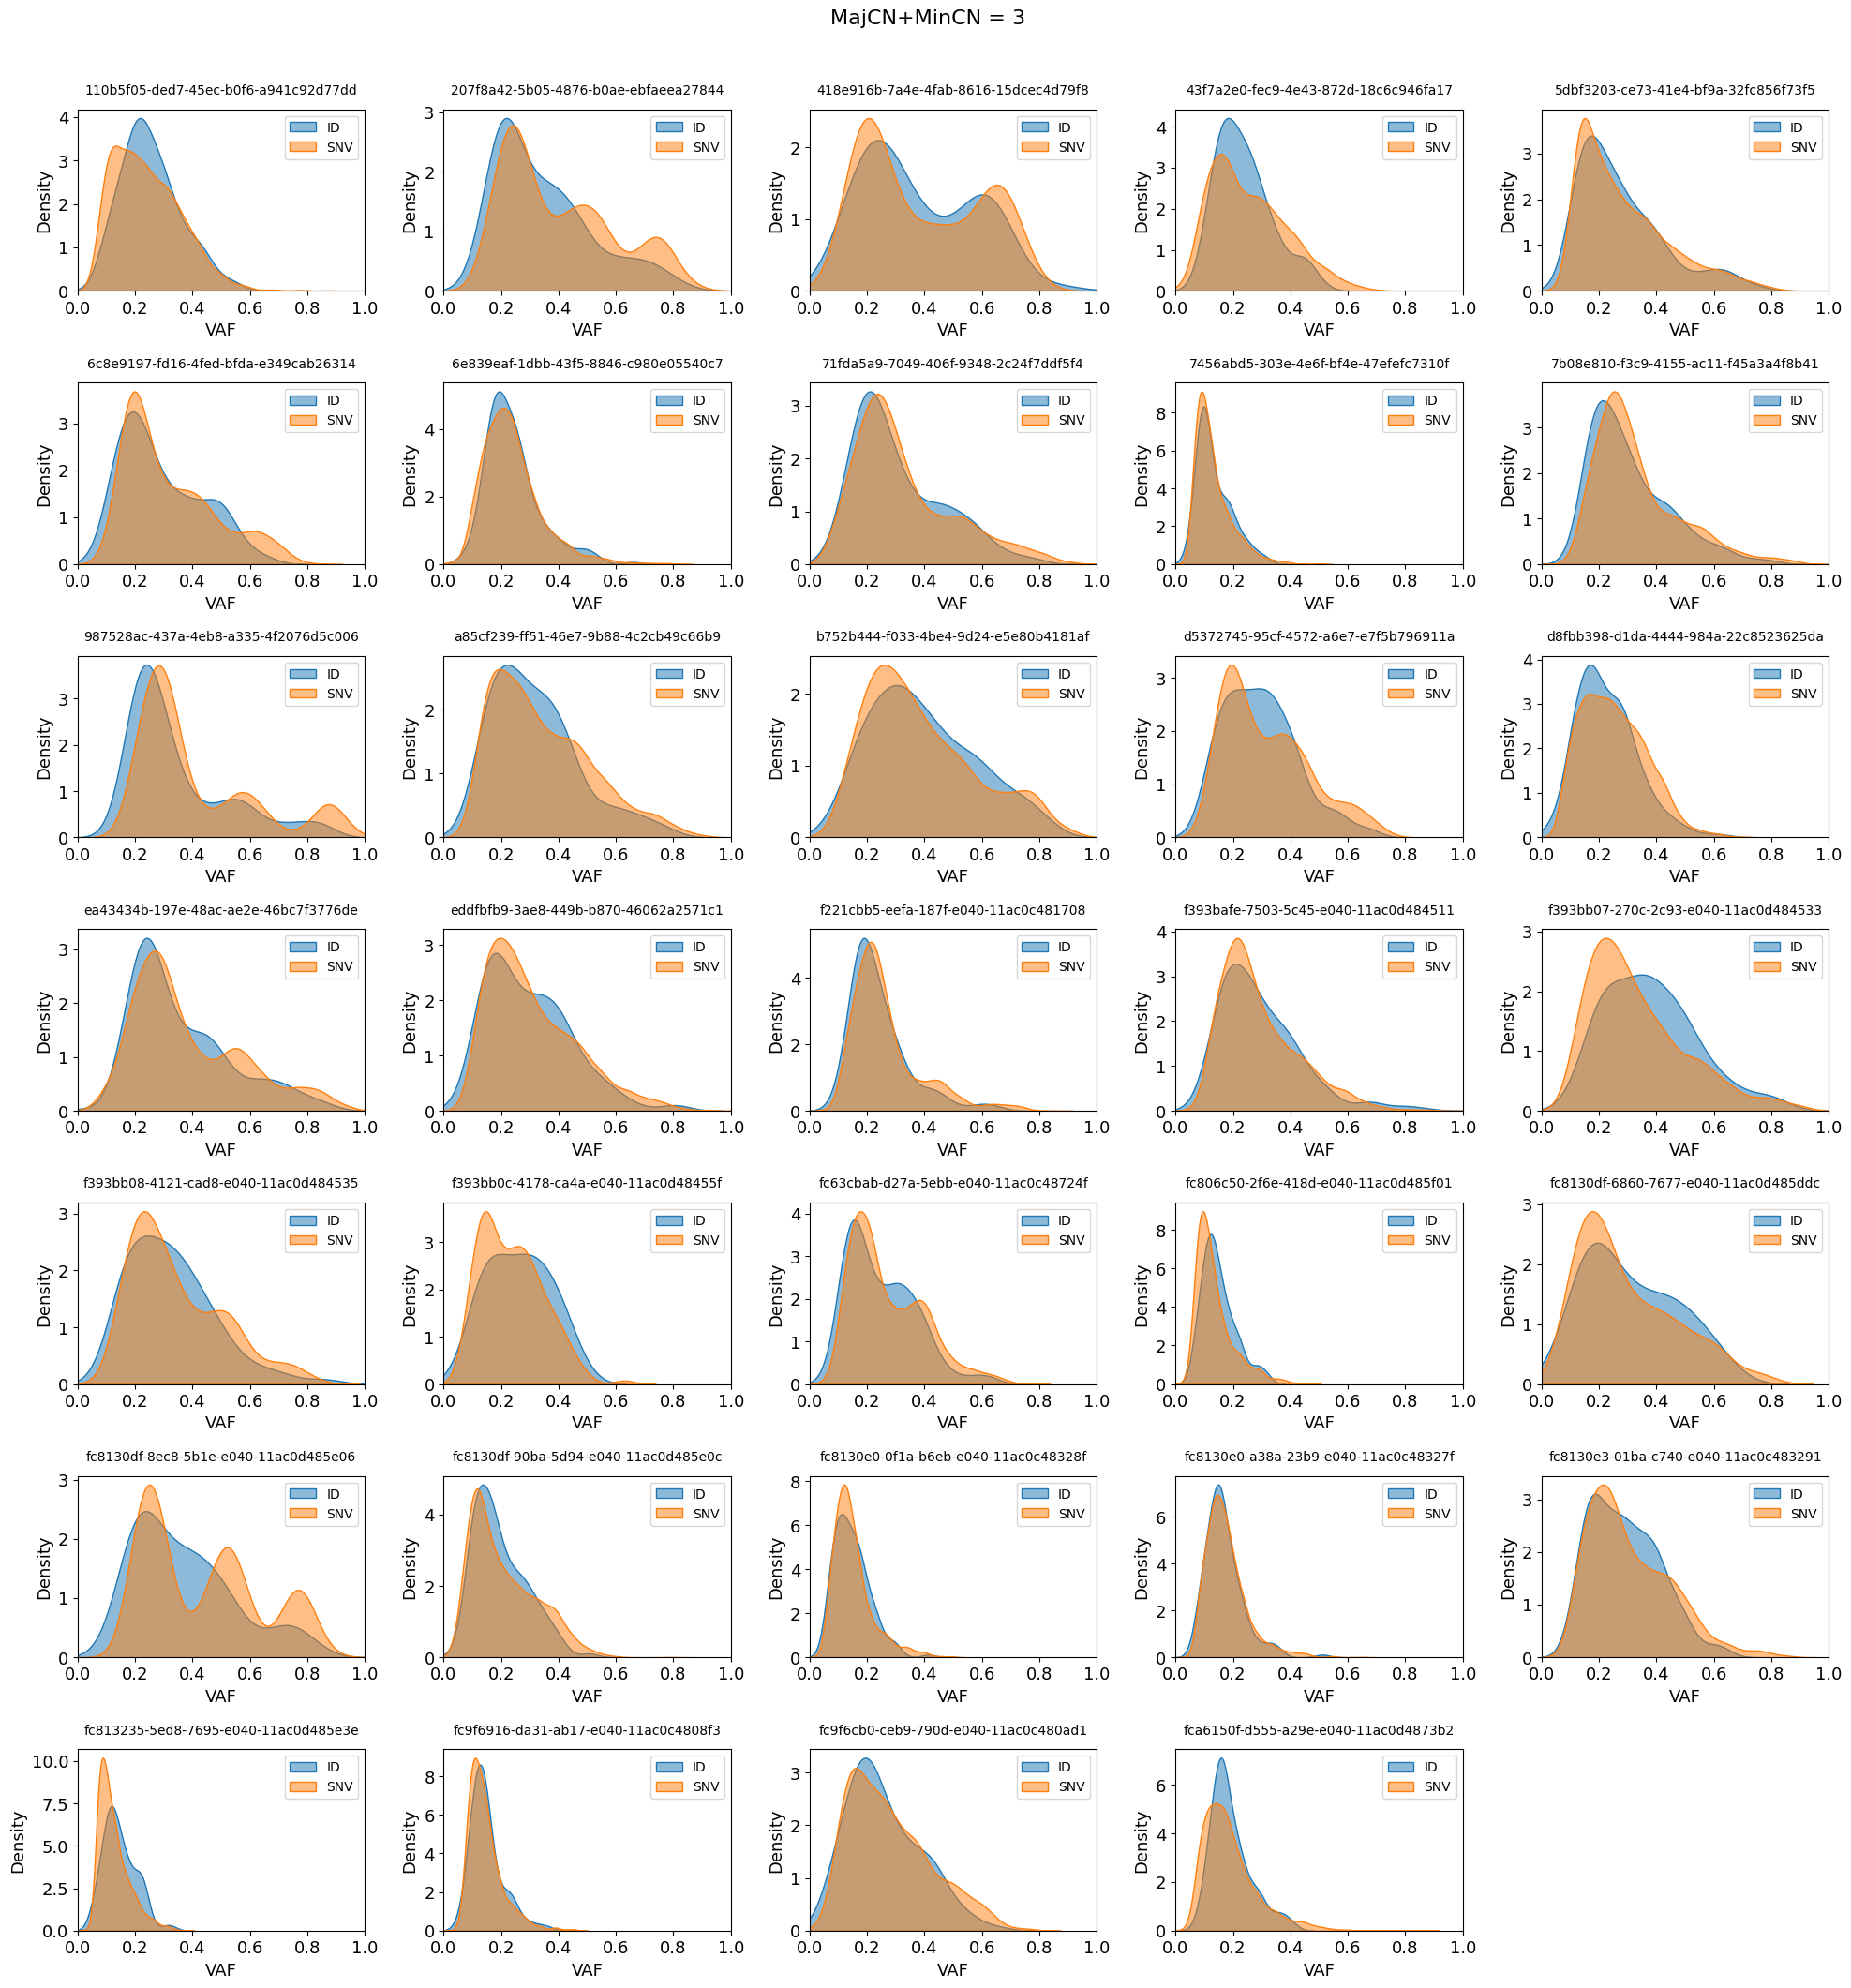

['110b5f05-ded7-45ec-b0f6-a941c92d77dd', '207f8a42-5b05-4876-b0ae-ebfaeea27844', '418e916b-7a4e-4fab-8616-15dcec4d79f8', '43f7a2e0-fec9-4e43-872d-18c6c946fa17', '5dbf3203-ce73-41e4-bf9a-32fc856f73f5', '6c8e9197-fd16-4fed-bfda-e349cab26314', '6e839eaf-1dbb-43f5-8846-c980e05540c7', '71fda5a9-7049-406f-9348-2c24f7ddf5f4', '7456abd5-303e-4e6f-bf4e-47efefc7310f', '7b08e810-f3c9-4155-ac11-f45a3a4f8b41', '987528ac-437a-4eb8-a335-4f2076d5c006', 'a85cf239-ff51-46e7-9b88-4c2cb49c66b9', 'b752b444-f033-4be4-9d24-e5e80b4181af', 'd5372745-95cf-4572-a6e7-e7f5b796911a', 'd8fbb398-d1da-4444-984a-22c8523625da', 'ea43434b-197e-48ac-ae2e-46bc7f3776de', 'eddfbfb9-3ae8-449b-b870-46062a2571c1', 'f221cbb5-eefa-187f-e040-11ac0c481708', 'f393bafe-7503-5c45-e040-11ac0d484511', 'f393bb07-270c-2c93-e040-11ac0d484533', 'f393bb08-4121-cad8-e040-11ac0d484535', 'f393bb0c-4178-ca4a-e040-11ac0d48455f', 'fc63cbab-d27a-5ebb-e040-11ac0c48724f', 'fc806c50-2f6e-418d-e040-11ac0d485f01', 'fc8130df-6860-7677-e040-11ac0d485ddc',

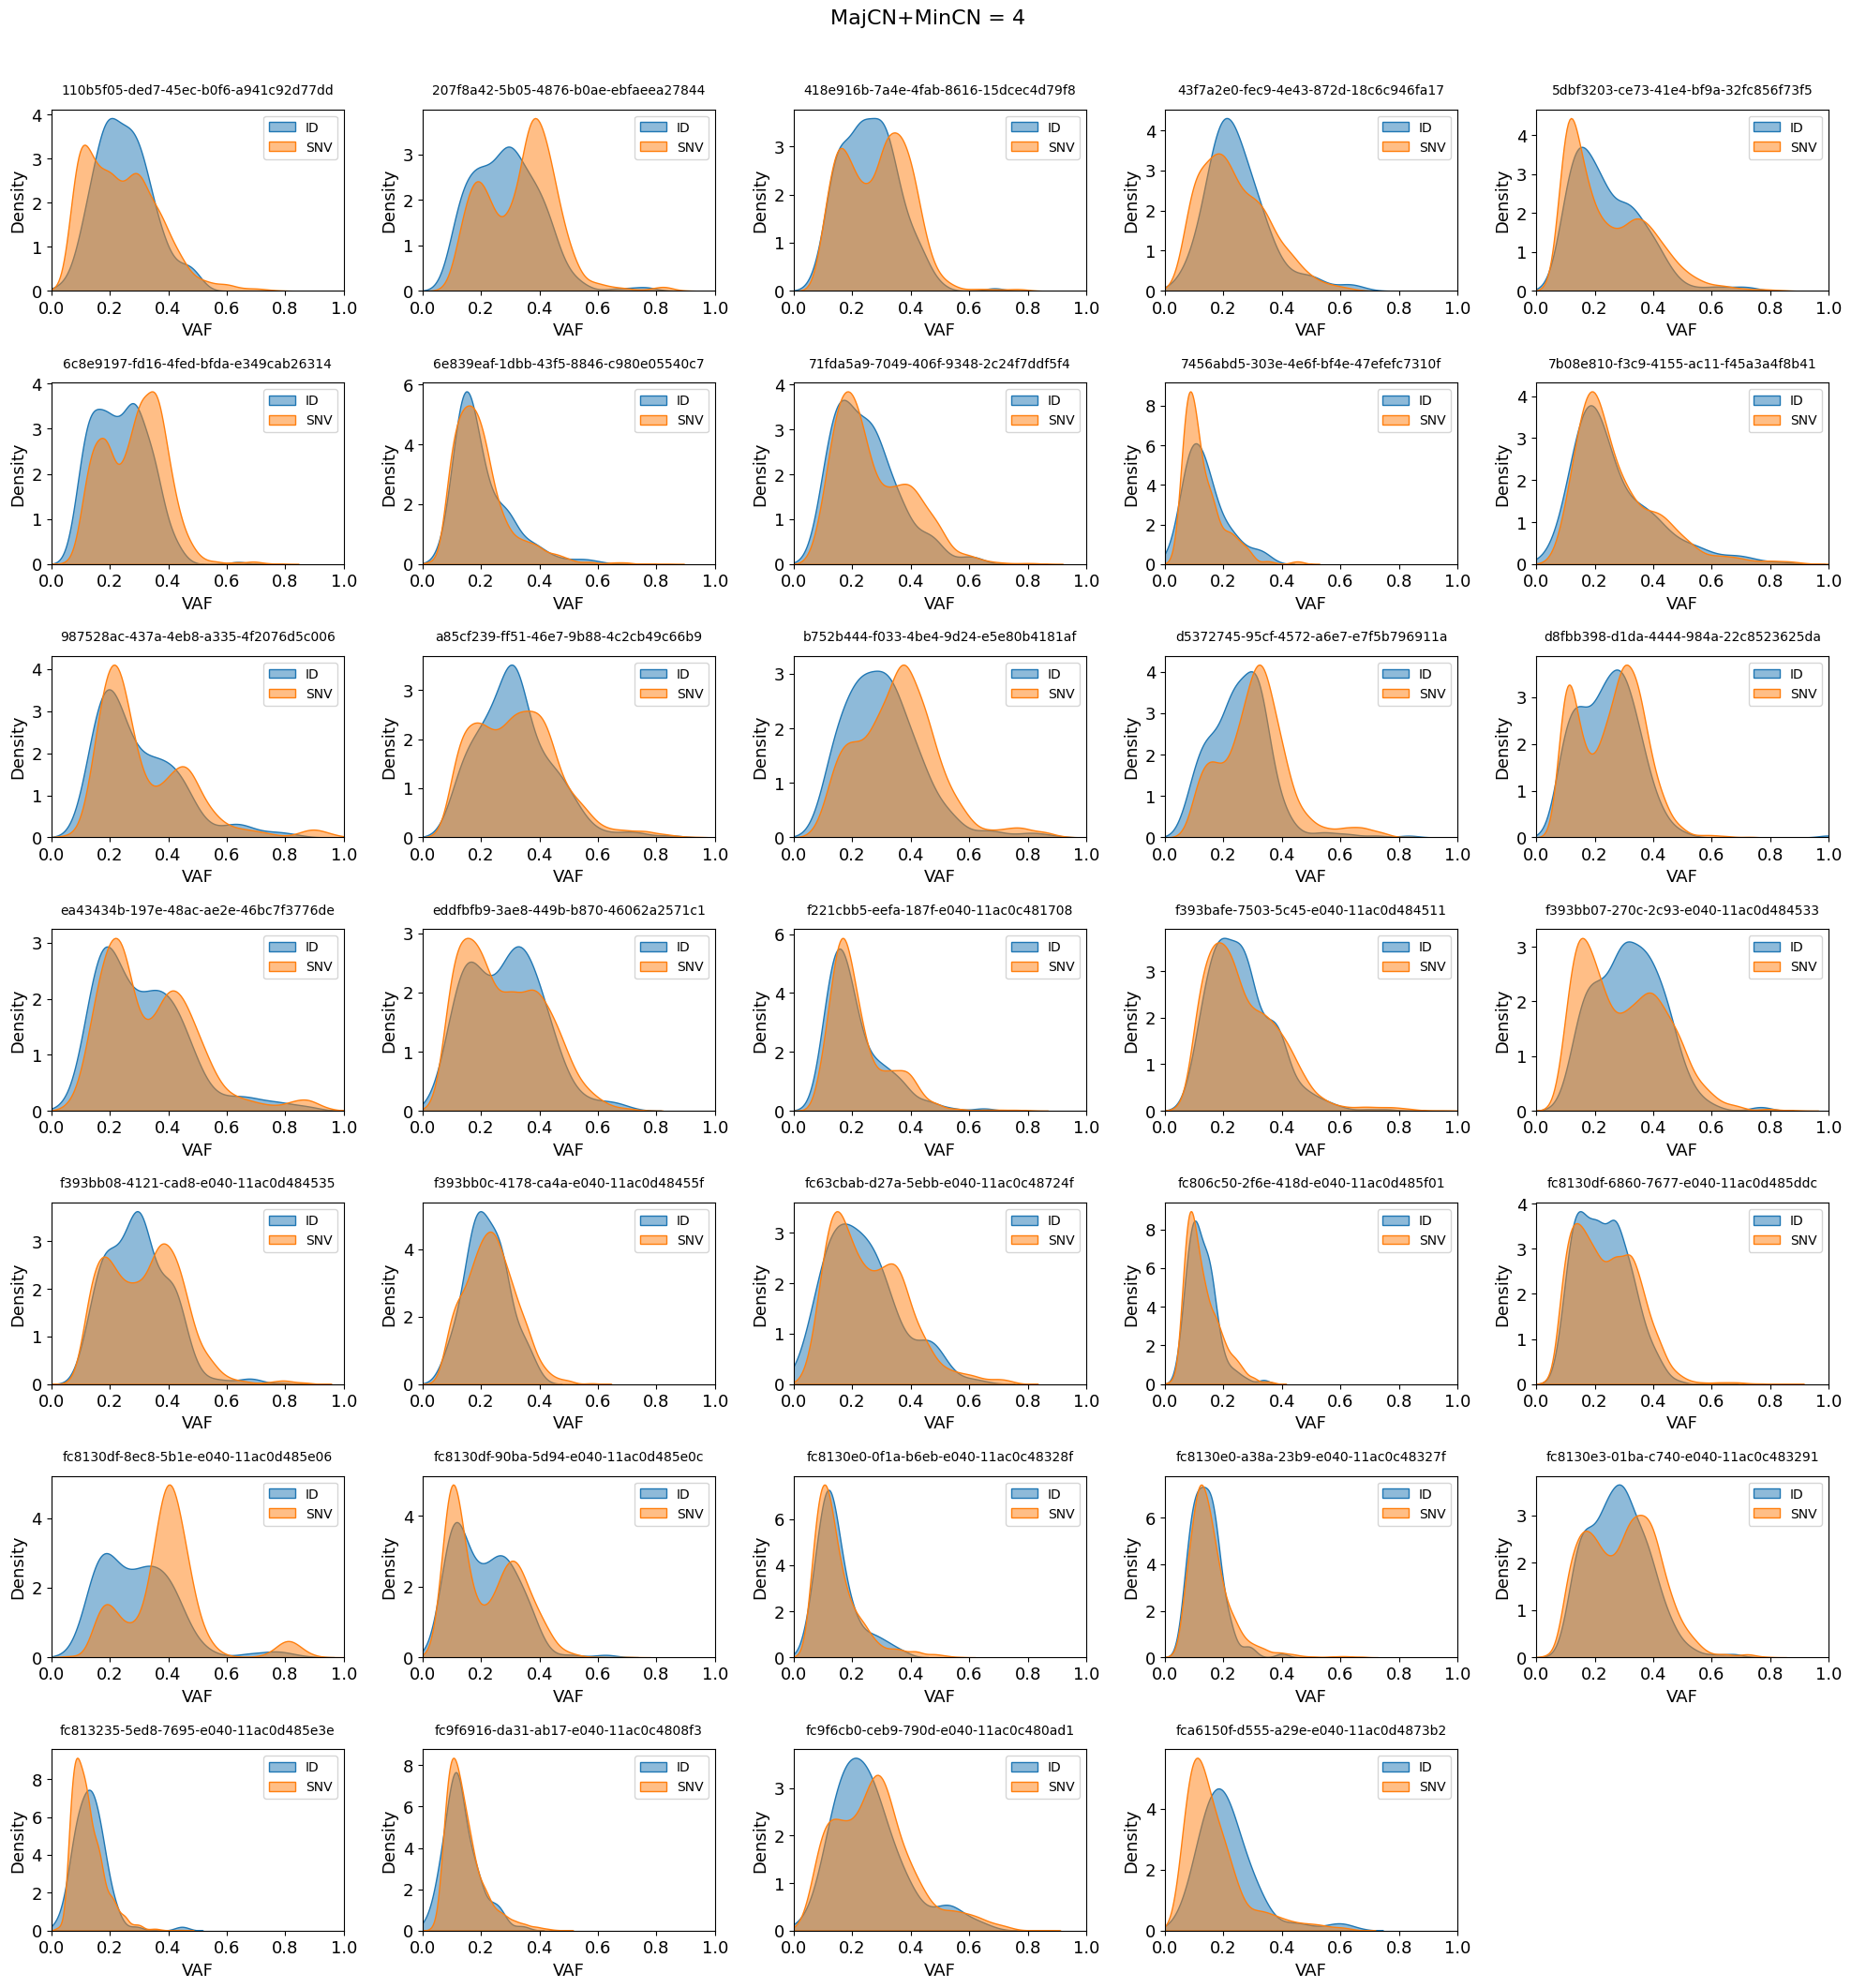

In [168]:
indel_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels"
snv_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_SNVs"

def extract_vaf_and_total_cn(info):
    vaf_match = re.search(r'VAF=([\d.]+)', info)
    mincn_match = re.search(r'MinCN=(\d+)', info)
    majcn_match = re.search(r'MajCN=(\d+)', info)
    
    vaf = float(vaf_match.group(1)) if vaf_match else None
    mincn = int(mincn_match.group(1)) if mincn_match else None
    majcn = int(majcn_match.group(1)) if majcn_match else None
    
    total_cn = (mincn + majcn) if (mincn is not None and majcn is not None) else None
    return vaf, total_cn

def collect_data(folder):
    data = {2: {}, 3: {}, 4: {}}
    for file in os.listdir(folder):
        if file.endswith('.vcf'):
            df = pd.read_csv(os.path.join(folder, file), sep='\t')
            sample_id = file.replace('.vcf', '')
            
            vaf_cn_pairs = df['INFO'].apply(lambda x: extract_vaf_and_total_cn(x)).dropna().tolist()
            
            for total_cn in [2, 3, 4]:
                vafs_for_cn = [v for v, cn in vaf_cn_pairs if cn == total_cn and v is not None]
                if vafs_for_cn:
                    data[total_cn].setdefault(sample_id, []).extend(vafs_for_cn)
    return data

indel_data = collect_data(indel_dir)
snv_data = collect_data(snv_dir)

for total_cn in [2, 3, 4]:
    samples = sorted(set(indel_data[total_cn]) | set(snv_data[total_cn]))
    print(samples)
    n_samples = len(samples)
    n_cols = 5
    n_rows = math.ceil(n_samples / n_cols)
    
    plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()
    
    for i, sample in enumerate(samples):
        ax = axes[i]
        if sample in indel_data[total_cn]:
            sns.kdeplot(indel_data[total_cn][sample], ax=ax, label='ID', color='tab:blue', fill=True, alpha=0.5)
        if sample in snv_data[total_cn]:
            sns.kdeplot(snv_data[total_cn][sample], ax=ax, label='SNV', color='tab:orange', fill=True, alpha=0.5)
        ax.set_title(f"{sample}", fontsize=10, y=1.04)
        ax.set_xlabel('VAF')
        ax.set_ylabel('Density')
        ax.legend(fontsize=10)
        ax.set_xlim(0,1)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(f'MajCN+MinCN = {total_cn}', fontsize=16, y=1.01)
    plt.tight_layout()
    plt.show()


## Prepare data for ID signature fitting (using MuSiCal)

In [5]:
# Get ID signatures that are for Breast set according to MuSiCal
catalog = musical.load_catalog('COSMIC_v3p1_Indel')
catalog.restrict_catalog(tumor_type='Breast.AdenoCA', is_MMRD=False, is_PPD=False)
Breast_ID_sigs = catalog.W.columns.tolist()
Musical_Type_vector = catalog.W.index.tolist()

ID_sigs_COSMIC_v3p4 = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/COSMIC_v3.4_ID_GRCh37 2.txt", sep='\t')
ID_sigs_COSMIC_v3p4 = ID_sigs_COSMIC_v3p4[Breast_ID_sigs]
ID_sigs_COSMIC_v3p4.index = Musical_Type_vector
ID_sigs_COSMIC_v3p4

ID1       ID2       ID3       ID4       ID5       ID6  \
DEL.C.1.1     1.598890e-04  0.004824  0.124727  0.007250  0.022202  0.030507   
DEL.C.1.2     7.735230e-04  0.000022  0.208876  0.002735  0.028547  0.005492   
DEL.C.1.3     3.310000e-18  0.000003  0.176324  0.002041  0.026597  0.008034   
DEL.C.1.4     1.907613e-03  0.002472  0.064043  0.001112  0.014159  0.001102   
DEL.C.1.5     7.059900e-04  0.003857  0.043990  0.001076  0.002873  0.002478   
...                    ...       ...       ...       ...       ...       ...   
DEL.MH.5+.1   8.160000e-07  0.000625  0.001370  0.000453  0.008617  0.071067   
DEL.MH.5+.2   2.380000e-10  0.000118  0.001751  0.000136  0.007851  0.253108   
DEL.MH.5+.3   2.330000e-12  0.000057  0.000775  0.001112  0.007158  0.216806   
DEL.MH.5+.4   3.880000e-05  0.000463  0.000641  0.003653  0.002493  0.120484   
DEL.MH.5+.5+  6.651160e-04  0.002367  0.000363  0.000046  0.001112  0.099283   

                   ID8           ID9      ID10          ID12          ID17  \
DEL.C.1.1     0.039828  3.349399e-01  0.025105  5.278774e-02  6.117599e-03   
DEL.C.1.2     0.023916  9.999423e-02  0.029306  1.467466e-02  3.667555e-03   
DEL.C.1.3     0.003331  2.690655e-03  0.018804  5.619320e-04  1.220327e-03   
DEL.C.1.4     0.005403  1.062542e-02  0.016504  9.955770e-04  2.260000e-08   
DEL.C.1.5     0.001276  1.249690e-02  0.002931  2.240050e-03  1.940000e-08   
...                ...           ...       ...           ...           ...   
DEL.MH.5+.1   0.280724  3.540000e-05  0.001330  5.633780e-04  2.077133e-02   
DEL.MH.5+.2   0.123610  2.212360e-04  0.000124  1.420000e-17  1.229006e-02   
DEL.MH.5+.3   0.046130  5.709070e-04  0.000056  3.235680e-04  8.596258e-03   
DEL.MH.5+.4   0.016367  4.483080e-04  0.000104  2.776630e-04  4.897913e-03   
DEL.MH.5+.5+  0.012815  5.410000e-18  0.041409  6.657973e-03  6.075636e-03   

                      ID18  
DEL.C.1.1     6.012048e-03  
DEL.C.1.2     2.004016e-03  
DEL.C.1.3     2.004016e-03  
DEL.C.1.4     4.008032e-03  
DEL.C.1.5     1.000000e-18  
...                    ...  
DEL.MH.5+.1   3.006024e-02  
DEL.MH.5+.2   2.204418e-02  
DEL.MH.5+.3   6.012048e-03  
DEL.MH.5+.4   4.008032e-03  
DEL.MH.5+.5+  1.000000e-18  

[83 rows x 12 columns]

## Create clonal ID mutation matrix

In [45]:
Analyze.cosmic_fit("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels",
                   "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels" + '/Alexandrov/', 
                   input_type="vcf", context_type="ID",
                   collapse_to_SBS96=False, cosmic_version=3.4, exome=False,
                   genome_build="GRCh37",
                   exclude_signature_subgroups=None, export_probabilities=False,
                   export_probabilities_per_mutation=False, make_plots=False,
                   sample_reconstruction_plots=False, verbose=False)

Starting matrix generation for INDELs...Completed! Elapsed time: 2.44 seconds.
Matrices generated for 34 samples with 0 errors. Total of 0 SNVs, 0 DINUCs, and 25415 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 34/34 [100%] in 2.0s (17.41/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


In [7]:
clonal_ID_mutation_matrix = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels/output/ID/Input_vcffiles.ID83.all", sep='\t', index_col=0)
clonal_ID_mutation_matrix.index = ID_sigs_COSMIC_v3p4.index
clonal_ID_mutation_matrix 

110b5f05-ded7-45ec-b0f6-a941c92d77dd  \
DEL.C.1.1                                       24   
DEL.C.1.2                                       15   
DEL.C.1.3                                        5   
DEL.C.1.4                                        1   
DEL.C.1.5                                        4   
...                                            ...   
DEL.MH.5+.1                                     44   
DEL.MH.5+.2                                     57   
DEL.MH.5+.3                                     31   
DEL.MH.5+.4                                     23   
DEL.MH.5+.5+                                    21   

              207f8a42-5b05-4876-b0ae-ebfaeea27844  \
DEL.C.1.1                                       47   
DEL.C.1.2                                       26   
DEL.C.1.3                                       13   
DEL.C.1.4                                        8   
DEL.C.1.5                                        3   
...                                            ...   
DEL.MH.5+.1                                    109   
DEL.MH.5+.2                                    128   
DEL.MH.5+.3                                     74   
DEL.MH.5+.4                                     48   
DEL.MH.5+.5+                                    28   

              418e916b-7a4e-4fab-8616-15dcec4d79f8  \
DEL.C.1.1                                       22   
DEL.C.1.2                                       21   
DEL.C.1.3                                        9   
DEL.C.1.4                                        3   
DEL.C.1.5                                        2   
...                                            ...   
DEL.MH.5+.1                                     23   
DEL.MH.5+.2                                     46   
DEL.MH.5+.3                                     30   
DEL.MH.5+.4                                     21   
DEL.MH.5+.5+                                    15   

              43f7a2e0-fec9-4e43-872d-18c6c946fa17  \
DEL.C.1.1                                       10   
DEL.C.1.2                                        3   
DEL.C.1.3                                        0   
DEL.C.1.4                                        0   
DEL.C.1.5                                        2   
...                                            ...   
DEL.MH.5+.1                                     36   
DEL.MH.5+.2                                     27   
DEL.MH.5+.3                                     12   
DEL.MH.5+.4                                      3   
DEL.MH.5+.5+                                     8   

              5dbf3203-ce73-41e4-bf9a-32fc856f73f5  \
DEL.C.1.1                                       59   
DEL.C.1.2                                       31   
DEL.C.1.3                                       11   
DEL.C.1.4                                        1   
DEL.C.1.5                                        3   
...                                            ...   
DEL.MH.5+.1                                    179   
DEL.MH.5+.2                                    193   
DEL.MH.5+.3                                    109   
DEL.MH.5+.4                                     50   
DEL.MH.5+.5+                                    44   

              6c8e9197-fd16-4fed-bfda-e349cab26314  \
DEL.C.1.1                                       29   
DEL.C.1.2                                       16   
DEL.C.1.3                                       11   
DEL.C.1.4                                        4   
DEL.C.1.5                                        3   
...                                            ...   
DEL.MH.5+.1                                     56   
DEL.MH.5+.2                                     88   
DEL.MH.5+.3                                     60   
DEL.MH.5+.4                                     37   
DEL.MH.5+.5+                                    27   

              6e839eaf-1dbb-43f5-8846-c980e05540c7  \
DEL.C.1.1                                       37   
DEL.C.1.2   

## Fit Breast ID Signatures

In [8]:
ID_exposures, model_ID = musical.refit.refit(clonal_ID_mutation_matrix, ID_sigs_COSMIC_v3p4, method='likelihood_bidirectional', thresh=0.001)
ID_exposures

110b5f05-ded7-45ec-b0f6-a941c92d77dd  \
ID1                              24.376404   
ID2                              12.513990   
ID3                              22.002452   
ID4                              20.154517   
ID5                              42.623430   
ID6                             155.284173   
ID8                             108.563207   
ID9                              38.174631   
ID10                              0.000000   
ID12                              0.000000   
ID17                              0.000000   
ID18                              0.000000   

      207f8a42-5b05-4876-b0ae-ebfaeea27844  \
ID1                              30.899430   
ID2                              31.272343   
ID3                              46.900697   
ID4                             114.970865   
ID5                               0.000000   
ID6                             319.887500   
ID8                             297.996210   
ID9                              53.500175   
ID10                             17.772061   
ID12                             12.455929   
ID17                              0.000000   
ID18                             48.974019   

      418e916b-7a4e-4fab-8616-15dcec4d79f8  \
ID1                              68.961646   
ID2                              96.533170   
ID3                              48.531143   
ID4                             100.194554   
ID5                              48.342413   
ID6                             145.640199   
ID8                              45.916586   
ID9                              24.875529   
ID10                             36.156751   
ID12                              0.000000   
ID17                              0.000000   
ID18                              0.000000   

      43f7a2e0-fec9-4e43-872d-18c6c946fa17  \
ID1                              28.620088   
ID2                              15.010165   
ID3                               0.000000   
ID4                              19.591666   
ID5                              17.916144   
ID6                              23.577755   
ID8                             152.047727   
ID9                               5.452892   
ID10                              6.267995   
ID12                              0.000000   
ID17                              8.655954   
ID18                              7.673644   

      5dbf3203-ce73-41e4-bf9a-32fc856f73f5  \
ID1                              17.765432   
ID2                              38.053427   
ID3                              36.147577   
ID4                              47.342967   
ID5                               8.956570   
ID6                             470.526046   
ID8                             447.073062   
ID9                              68.103210   
ID10                              0.000000   
ID12                              0.000000   
ID17                              0.000000   
ID18                              0.000000   

      6c8e9197-fd16-4fed-bfda-e349cab26314  \
ID1                              42.781566   
ID2                              34.296580   
ID3                              43.281544   
ID4                              12.427040   
ID5                              30.186971   
ID6                             272.478810   
ID8                             120.880417   
ID9                              26.155695   
ID10                              0.000000   
ID12                              0.000000   
ID17                              9.510965   
ID18                              0.000000   

      6e839eaf-1dbb-43f5-8846-c980e05540c7  \
ID1                             137.057609   
ID2                              58.581691   
ID3                              21.978178   
ID4                              47.346721   
ID5                              33.916855   
ID6                             178.956158   
ID8                             153.356079   
ID9                              59.463515  

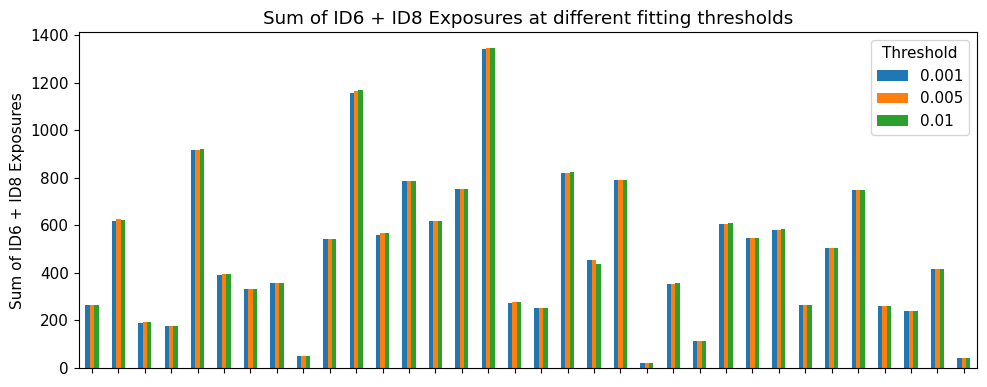

In [57]:
thresholds = [0.001, 0.005, 0.01]
results = {}

for thresh in thresholds:
    ID_exposures, model_ID = musical.refit.refit(
        clonal_ID_mutation_matrix,
        ID_sigs_COSMIC_v3p4,
        method='likelihood_bidirectional',
        thresh=thresh
    )
    sums = ID_exposures.loc[['ID6', 'ID8']].sum(axis=0)
    results[thresh] = sums

plot_df = pd.DataFrame(results)

plt.rcParams.update({'font.size': 11, 'pdf.fonttype': 42})
ax = plot_df.plot(kind='bar', figsize=(10, 4))
ax.set_ylabel('Sum of ID6 + ID8 Exposures')
ax.set_title('Sum of ID6 + ID8 Exposures at different fitting thresholds')
ax.legend(title='Threshold', fontsize=11)
ax.set_xticklabels([])
plt.tight_layout()
plt.show()


## pi1 analysis + VAF plots for samples with low pi1SBS3

In [9]:
timing_data = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")
sample_ids = set(timing_data[timing_data['cohort'] == 'PCAWG']['ID'].tolist())

input_dir = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/PCAWG_Indels/vcfs"
output_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels"
os.makedirs(output_dir, exist_ok=True)

id_clonal_dfs = {}

for file in os.listdir(input_dir):
    if not file.endswith('.vcf'):
        continue
    sample_id = file[:-4]  # remove '.vcf'
    if sample_id not in sample_ids:
        continue

    with open(os.path.join(input_dir, file)) as f:
        lines = f.readlines()
    data_lines = [l for l in lines if not l.startswith('##')]
    df = pd.read_csv(StringIO(''.join(data_lines)), sep='\t')
    clonal = df[df['INFO'].str.contains(r'CLS=clonal\b', na=False)]
    if not clonal.empty:
        id_clonal_dfs[sample_id] = clonal

In [10]:
def get_mutation_type_dict(folder_path, mapping):
    dfs = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            if os.path.getsize(file_path) == 0:
                continue
            df = pd.read_csv(file_path, sep='\t', header=None)
            df.columns = ['Sample', '#CHROM', 'POS', 'Mutation', 'REF', 'ALT', 'Strand']
            df['#CHROM'] = df['#CHROM'].astype(str).str.replace('chr', '', regex=False)
            df['MutationType_COSMIC'] = df['Mutation'].str[2:11]
            df['MutationType_MuSiCal'] = df['MutationType_COSMIC'].map(mapping)
            dfs.append(df)
    if dfs:
        combined = pd.concat(dfs, ignore_index=True)
        grouped = {
            sample: group.drop(columns='Sample').reset_index(drop=True)
            for sample, group in combined.groupby('Sample')
        }
        return grouped
    return {}

def append_signature_probabilities(sample_df, sample_name, H_reduced_normalized, W_reduced):
    if sample_name not in H_reduced_normalized.columns:
        return sample_df
    weights = H_reduced_normalized[sample_name]
    weighted = W_reduced.multiply(weights, axis=1)
    probs = weighted.div(weighted.sum(axis=1), axis=0)
    for signature in probs.columns:
        prob_map = probs[signature]
        sample_df[f'prob_{signature}'] = sample_df['MutationType_MuSiCal'].map(prob_map)
    return sample_df

COSMIC_ID_83 = pd.read_csv(
    '/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels/output/ID/Input_vcffiles.ID83.all',
    sep='\t'
)['MutationType']
MUSICAL_ID_83 = ID_sigs_COSMIC_v3p4.index
mapping = dict(zip(COSMIC_ID_83, MUSICAL_ID_83))

mut_dict = get_mutation_type_dict(
    '/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels/output/vcf_files/ID',
    mapping
)

mut_dict = {
    sample: append_signature_probabilities(df, sample, model_ID.H_reduced_normalized, model_ID.W_reduced)
    for sample, df in mut_dict.items()
}

In [11]:
sig_annotated_clonal_id = {
    sample: pd.merge(
        mut_df,
        id_clonal_dfs[sample],
        on=['#CHROM', 'POS', 'REF', 'ALT'],
        how='inner'
    )
    for sample, mut_df in mut_dict.items()
    if sample in id_clonal_dfs
}

fields = ['MajCN', 'MinCN', 'MutCN', 'pSingle', 'pGain']

def extract_info_fields(df):
    for field in fields:
        df[field] = df['INFO'].str.extract(fr'{field}=([^;]+)').astype(float)
    return df

sig_annotated_clonal_id = {sample: extract_info_fields(df) for sample, df in sig_annotated_clonal_id.items()}

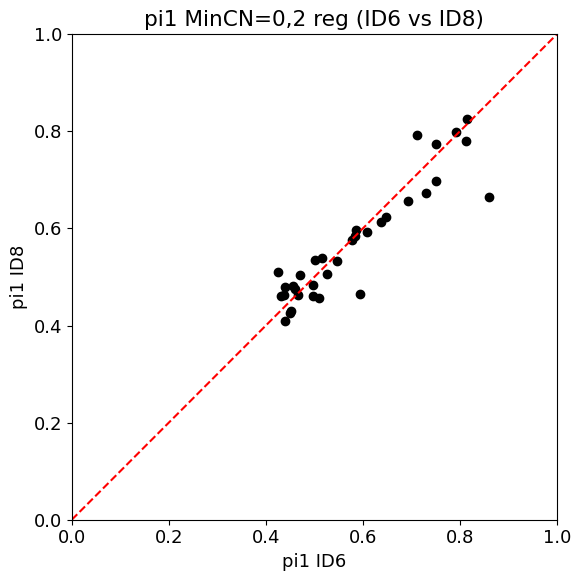

In [14]:
pi2_ID8_results_dict = {}
minCN_counts_dict = {}

for sample_id, df in sig_annotated_clonal_id.items():
    pi_2_ID8 = {0: np.nan, 1: np.nan, 2: np.nan}
    minCN_counts = {}

    for min_cn in [0, 1, 2]:
        subset = df[df['MinCN'] == min_cn]
        minCN_counts[min_cn] = len(subset)

        sum_num_ID8 = 0
        sum_pi_ID8 = 0

        for _, row in subset.iterrows():
            prob_id8 = row['prob_ID8']
            p_gain = row['pGain']
            p_single = row['pSingle']

            if (p_single + p_gain) != 0:
                sum_num_ID8 += prob_id8 * p_single
            sum_pi_ID8 += prob_id8

        pi_2_ID8[min_cn] = sum_num_ID8 / sum_pi_ID8 if sum_pi_ID8 != 0 else np.nan

    pi2_ID8_results_dict[sample_id] = pi_2_ID8
    minCN_counts_dict[sample_id] = minCN_counts

# Compute pi2_ID6_results_dict
pi2_ID6_results_dict = {}
for key, df in sig_annotated_clonal_id.items():
    pi2_ID6 = {0: np.nan, 1: np.nan, 2: np.nan}
    for min_cn in [0, 1, 2]:
        subsample = df[df['MinCN'] == min_cn]
        sum_num = 0
        sum_pi = 0
        for _, row in subsample.iterrows():
            prob_id6 = row['prob_ID6']
            p_gain = row['pGain']
            p_single = row['pSingle']
            sum_num += prob_id6 * p_single
            sum_pi += prob_id6
        pi2_ID6[min_cn] = sum_num / sum_pi if sum_pi != 0 else np.nan
    pi2_ID6_results_dict[key] = pi2_ID6

# Compute weighted averages
weighted_pi2_ID6 = {}
weighted_pi2_ID8 = {}

for sample in pi2_ID8_results_dict.keys():
    pi2_0_ID8 = pi2_ID8_results_dict[sample].get(0, np.nan)
    pi2_2_ID8 = pi2_ID8_results_dict[sample].get(2, np.nan)
    pi2_0_ID6 = pi2_ID6_results_dict[sample].get(0, np.nan)
    pi2_2_ID6 = pi2_ID6_results_dict[sample].get(2, np.nan)

    n0 = minCN_counts_dict[sample].get(0, 0)
    n2 = minCN_counts_dict[sample].get(2, 0)
    total = n0 + n2

    if total > 0:
        if not pd.isna(pi2_0_ID8) and not pd.isna(pi2_2_ID8):
            weighted_pi2_ID8[sample] = (pi2_0_ID8 * n0 + pi2_2_ID8 * n2) / total
        else:
            weighted_pi2_ID8[sample] = np.nan

        if not pd.isna(pi2_0_ID6) and not pd.isna(pi2_2_ID6):
            weighted_pi2_ID6[sample] = (pi2_0_ID6 * n0 + pi2_2_ID6 * n2) / total
        else:
            weighted_pi2_ID6[sample] = np.nan
    else:
        weighted_pi2_ID8[sample] = np.nan
        weighted_pi2_ID6[sample] = np.nan

# Plot
df_corr = pd.DataFrame({
    'pi2_ID6_weighted': pd.Series(weighted_pi2_ID6),
    'pi2_ID8_weighted': pd.Series(weighted_pi2_ID8)
}).dropna()

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})
plt.scatter(df_corr['pi2_ID6_weighted'], df_corr['pi2_ID8_weighted'], alpha=1, color='k')
plt.plot([0,1], [0,1], 'r--')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('pi1 ID6')
plt.ylabel('pi1 ID8')
plt.title('pi1 MinCN=0,2 reg (ID6 vs ID8)')
plt.tight_layout()
plt.show()


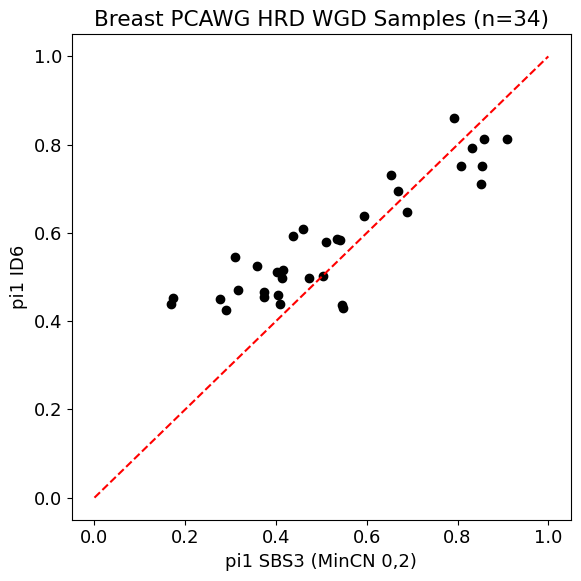

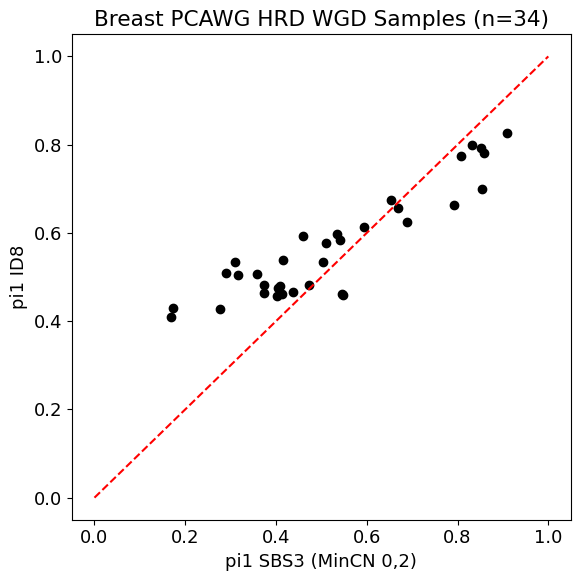

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the file
df_all = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")

# Parse pi2_SBS1 and N_mut_all strings into lists of floats
def parse_list_column(col):
    return col.apply(lambda x: [float(i) for i in x.strip('[]').split(', ')] if pd.notnull(x) else [])

df_all['pi2_SBS3_list'] = parse_list_column(df_all['pi1SBS3'])
df_all['N_mut_all_list'] = parse_list_column(df_all['N_mut_all'])

# Compute weighted average of pi2_SBS1 at indices 0 and 2
def weighted_pi2_sbs1(row):
    pi2_list = row['pi2_SBS3_list']
    nmut_list = row['N_mut_all_list']
    if len(pi2_list) >= 3 and len(nmut_list) >= 3:
        num = pi2_list[0] * nmut_list[0] + pi2_list[2] * nmut_list[2]
        denom = nmut_list[0] + nmut_list[2]
        return num / denom if denom > 0 else np.nan
    else:
        return np.nan

df_all['pi2_SBS3_weighted_0_2'] = df_all.apply(weighted_pi2_sbs1, axis=1)

# Combine with weighted_pi2_ID6 and ID8 (from previous step)
df_corr = pd.DataFrame({
    'pi2_ID6_weighted': pd.Series(weighted_pi2_ID6),
    'pi2_ID8_weighted': pd.Series(weighted_pi2_ID8)
})
df_corr = df_corr.merge(df_all[['ID', 'pi2_SBS3_weighted_0_2']], left_index=True, right_on='ID', how='left')

# Plot ID6
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})
plt.scatter(df_corr['pi2_SBS3_weighted_0_2'],df_corr['pi2_ID6_weighted'], alpha=1, color='k')
plt.xlabel('pi1 SBS3 (MinCN 0,2)')
plt.ylabel('pi1 ID6')
plt.plot([0,1], [0,1], 'r--')
plt.title("Breast PCAWG HRD WGD Samples (n=34)")
plt.tight_layout()
plt.show()

# Plot ID8
plt.figure(figsize=(6,6))
plt.scatter(df_corr['pi2_SBS3_weighted_0_2'], df_corr['pi2_ID8_weighted'], alpha=1, color='k')
plt.xlabel('pi1 SBS3 (MinCN 0,2)')
plt.ylabel('pi1 ID8')
plt.plot([0,1], [0,1], 'r--')
plt.title("Breast PCAWG HRD WGD Samples (n=34)")
plt.tight_layout()
plt.show()


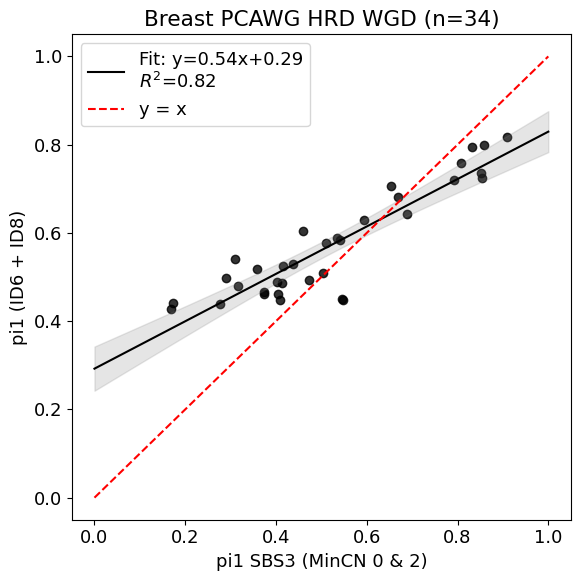

In [21]:
combined_pi2_results = {}
minCN_counts_dict = {}

for sample_id, df in sig_annotated_clonal_id.items():
    combined_pi2 = {}
    minCN_counts = {}

    for min_cn in [0, 1, 2]:
        subset = df[df['MinCN'] == min_cn]
        minCN_counts[min_cn] = len(subset)

        sum_num_combined = 0
        sum_pi_combined = 0

        for _, row in subset.iterrows():
            p_gain = row['pGain']
            p_single = row['pSingle']
            denom = 1

            prob_id6 = row.get('prob_ID6', 0) or 0
            prob_id8 = row.get('prob_ID8', 0) or 0
            prob_combined = prob_id6 + prob_id8

            if denom and denom != 0:
                sum_num_combined += prob_combined * p_single / denom
            sum_pi_combined += prob_combined

        combined_pi2[min_cn] = sum_num_combined / sum_pi_combined if sum_pi_combined != 0 else np.nan

    combined_pi2_results[sample_id] = combined_pi2
    minCN_counts_dict[sample_id] = minCN_counts

weighted_combined_pi2 = {}

for sample in combined_pi2_results.keys():
    n0 = minCN_counts_dict[sample].get(0, 0)
    n2 = minCN_counts_dict[sample].get(2, 0)
    total = n0 + n2

    pi2_0 = combined_pi2_results[sample].get(0, np.nan)
    pi2_2 = combined_pi2_results[sample].get(2, np.nan)

    if total > 0 and not (pd.isna(pi2_0) or pd.isna(pi2_2)):
        weighted_combined_pi2[sample] = (pi2_0 * n0 + pi2_2 * n2) / total
    else:
        weighted_combined_pi2[sample] = np.nan

# Load your CSV with pi2_SBS1 and N_mut_all
df_all = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")

def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return np.nan  # or [] if you prefer

df_all['pi1_SBS3_list'] = df_all['pi1SBS3'].apply(safe_literal_eval)
df_all['N_mut_all_list'] = df_all['N_mut_all'].apply(safe_literal_eval)

weighted_pi2_SBS1 = {}

for _, row in df_all.iterrows():
    sample_id = row['ID']
    pi2_list = row['pi1_SBS3_list']
    n_mut_list = row['N_mut_all_list']

    # Check pi2_list and n_mut_list are lists and valid length
    if (isinstance(pi2_list, list) and isinstance(n_mut_list, list) and
        len(pi2_list) > 2 and len(n_mut_list) > 2):

        n0 = n_mut_list[0]
        n2 = n_mut_list[2]
        total = n0 + n2

        pi2_0 = pi2_list[0]
        pi2_2 = pi2_list[2]

        if total > 0 and not (np.isnan(pi2_0) or np.isnan(pi2_2)):
            weighted_pi2_SBS1[sample_id] = (pi2_0 * n0 + pi2_2 * n2) / total
        else:
            weighted_pi2_SBS1[sample_id] = np.nan
    else:
        weighted_pi2_SBS1[sample_id] = np.nan

# Prepare data for plotting, matching samples between the two results
combined_samples = set(weighted_combined_pi2.keys()) & set(weighted_pi2_SBS1.keys())

from scipy.stats import linregress
import statsmodels.api as sm

x_vals = [weighted_combined_pi2[s] for s in combined_samples]
y_vals = [weighted_pi2_SBS1[s] for s in combined_samples]

x_clean, y_clean = [], []
for x, y in zip(x_vals, y_vals):
    if not (np.isnan(x) or np.isnan(y)):
        x_clean.append(x)
        y_clean.append(y)

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})
plt.scatter(y_clean, x_clean, color='k', alpha=0.8)

# Linear regression with statsmodels to get confidence intervals
X = sm.add_constant(y_clean)  # Add intercept
model = sm.OLS(x_clean, X)
results = model.fit()

# Prediction values and confidence intervals
x_pred = np.linspace(0, 1, 100)
X_pred = sm.add_constant(x_pred)
predictions = results.get_prediction(X_pred)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Plot regression line and confidence interval
plt.plot(x_pred, pred_summary['mean'], 'k-', label=f'Fit: y={results.params[1]:.2f}x+{results.params[0]:.2f}\n$R^2$={results.rsquared:.2f}')
plt.fill_between(x_pred, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color='grey', alpha=0.2)

plt.plot([0, 1], [0, 1], 'r--', label='y = x')
plt.ylabel('pi1 (ID6 + ID8)')
plt.xlabel('pi1 SBS3 (MinCN 0 & 2)')
plt.legend()
plt.title("Breast PCAWG HRD WGD (n=34)")
plt.tight_layout()
plt.show()



INFO - maxp pruned
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - FFTM dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 5 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'R', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 53]
INFO - Closed glyph list over 'GSUB': 5 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'R', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 53]
INFO - Closing glyph list over 'glyf': 5 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'R', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 53]
INFO - Closed glyph list over 'glyf': 5 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'R', 'nonmarkingreturn', 'space']
INFO - Glyph IDs:   [0, 1, 2, 3, 53]
INFO - Retaining 5 glyphs
INFO - head subsetting not needed
INFO - hhea subsetting not needed
INFO - maxp subsett

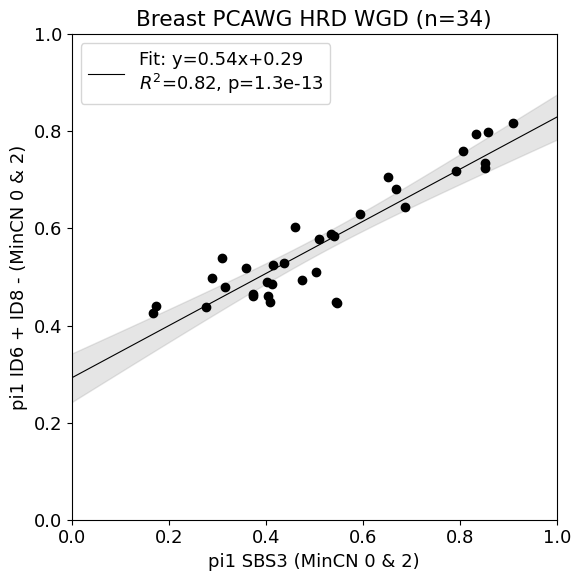

In [30]:
import pandas as pd, numpy as np, ast, matplotlib.pyplot as plt, statsmodels.api as sm

# Compute combined_pi2_results & minCN_counts_dict
combined_pi2_results, minCN_counts_dict = {}, {}
for sid, df in sig_annotated_clonal_id.items():
    combined_pi2 = {}
    minCN_counts = {cn: len(df[df['MinCN'] == cn]) for cn in [0, 1, 2]}
    for cn in [0, 1, 2]:
        sub = df[df['MinCN'] == cn]
        prob = (sub.get('prob_ID6', 0).fillna(0) + sub.get('prob_ID8', 0).fillna(0)).values
        p_single = sub['pSingle'].values
        num = np.sum(prob * p_single)
        denom = np.sum(prob)
        combined_pi2[cn] = num / denom if denom else np.nan
    combined_pi2_results[sid] = combined_pi2
    minCN_counts_dict[sid] = minCN_counts

# Weighted combined_pi2
weighted_combined_pi2 = {
    sid: (
        (combined_pi2_results[sid][0] * minCN_counts_dict[sid][0] +
         combined_pi2_results[sid][2] * minCN_counts_dict[sid][2]) /
        (minCN_counts_dict[sid][0] + minCN_counts_dict[sid][2])
        if (minCN_counts_dict[sid][0] + minCN_counts_dict[sid][2] > 0 and
            not pd.isna(combined_pi2_results[sid][0]) and
            not pd.isna(combined_pi2_results[sid][2])) else np.nan
    )
    for sid in combined_pi2_results
}

# Read and process pi1_SBS3
df_all = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/All_data_Jun11.csv")
df_all = df_all[df_all['cohort'] == 'PCAWG']
safe_eval = lambda x: ast.literal_eval(x)

def safe_literal_eval(x):
    if isinstance(x, str) and (x.startswith('[') or x.startswith('(')):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return np.nan
    return np.nan

df_all['pi1_SBS3_list'] = df_all['pi1SBS3'].apply(safe_literal_eval)
df_all['N_mut_all_list'] = df_all['N_mut_all'].apply(safe_literal_eval)

weighted_pi2_SBS1 = {}
low_weighted_pi1_sbs3_samples = []

for _, row in df_all.iterrows():
    sid, pi, n = row['ID'], row['pi1_SBS3_list'], row['N_mut_all_list']
    
    if isinstance(pi, list) and isinstance(n, list) and len(pi) > 2 and len(n) > 2:
        n0, n2 = n[0], n[2]
        pi0, pi2 = pi[0], pi[2]
        t = n0 + n2

        if t > 0 and not (np.isnan(pi0) or np.isnan(pi2)):
            weighted_val = (pi0 * n0 + pi2 * n2) / t
            weighted_pi2_SBS1[sid] = weighted_val
            if weighted_val < 0.45:
                low_weighted_pi1_sbs3_samples.append(sid)
        else:
            weighted_pi2_SBS1[sid] = np.nan
    else:
        weighted_pi2_SBS1[sid] = np.nan

# Prepare and plot
samples = set(weighted_combined_pi2) & set(weighted_pi2_SBS1)
x, y = zip(*[(weighted_combined_pi2[s], weighted_pi2_SBS1[s]) for s in samples if not (np.isnan(weighted_combined_pi2[s]) or np.isnan(weighted_pi2_SBS1[s]))])

plt.figure(figsize=(6,6))
plt.scatter(y, x, c='k', edgecolors='black', alpha=1, zorder=20)

X = sm.add_constant(y)
model = sm.OLS(x, X).fit()

xp = np.linspace(0,1,100)
Xp = sm.add_constant(xp)
pred = model.get_prediction(Xp).summary_frame()

plt.plot(xp, pred['mean'], 'k-', linewidth=0.8,
         label=f'Fit: y={model.params[1]:.2f}x+{model.params[0]:.2f}\n'
               f'$R^2$={model.rsquared:.2f}, p={model.pvalues[1]:.3g}')
plt.fill_between(xp, pred['mean_ci_lower'], pred['mean_ci_upper'], color='grey', alpha=0.2)

# plt.plot([0,1],[0,1],'r--',label='y=x')  # Uncomment if you want reference line
plt.xlabel('pi1 SBS3 (MinCN 0 & 2)')
plt.ylabel('pi1 ID6 + ID8 - (MinCN 0 & 2)')
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.title('Breast PCAWG HRD WGD (n={})'.format(len(x)))
plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/pi1_ID6_ID8_pi1_SBS3_20_22.pdf", format='pdf', bbox_inches='tight')
plt.show()



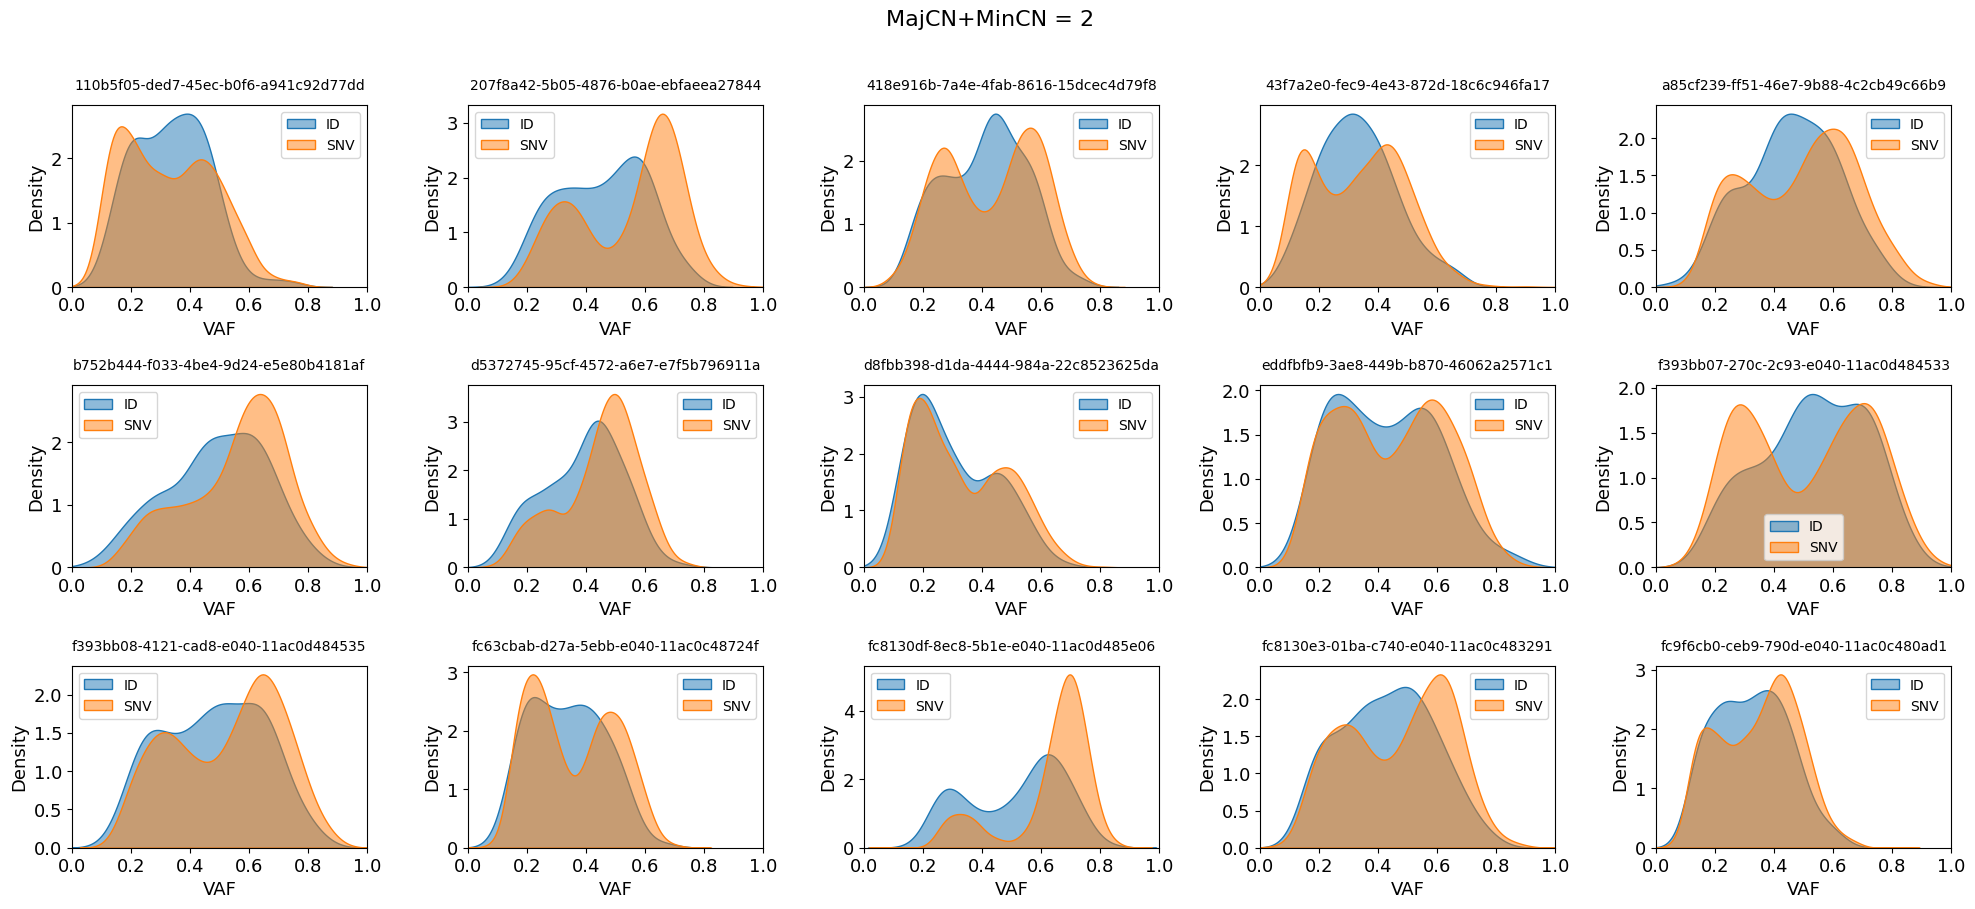

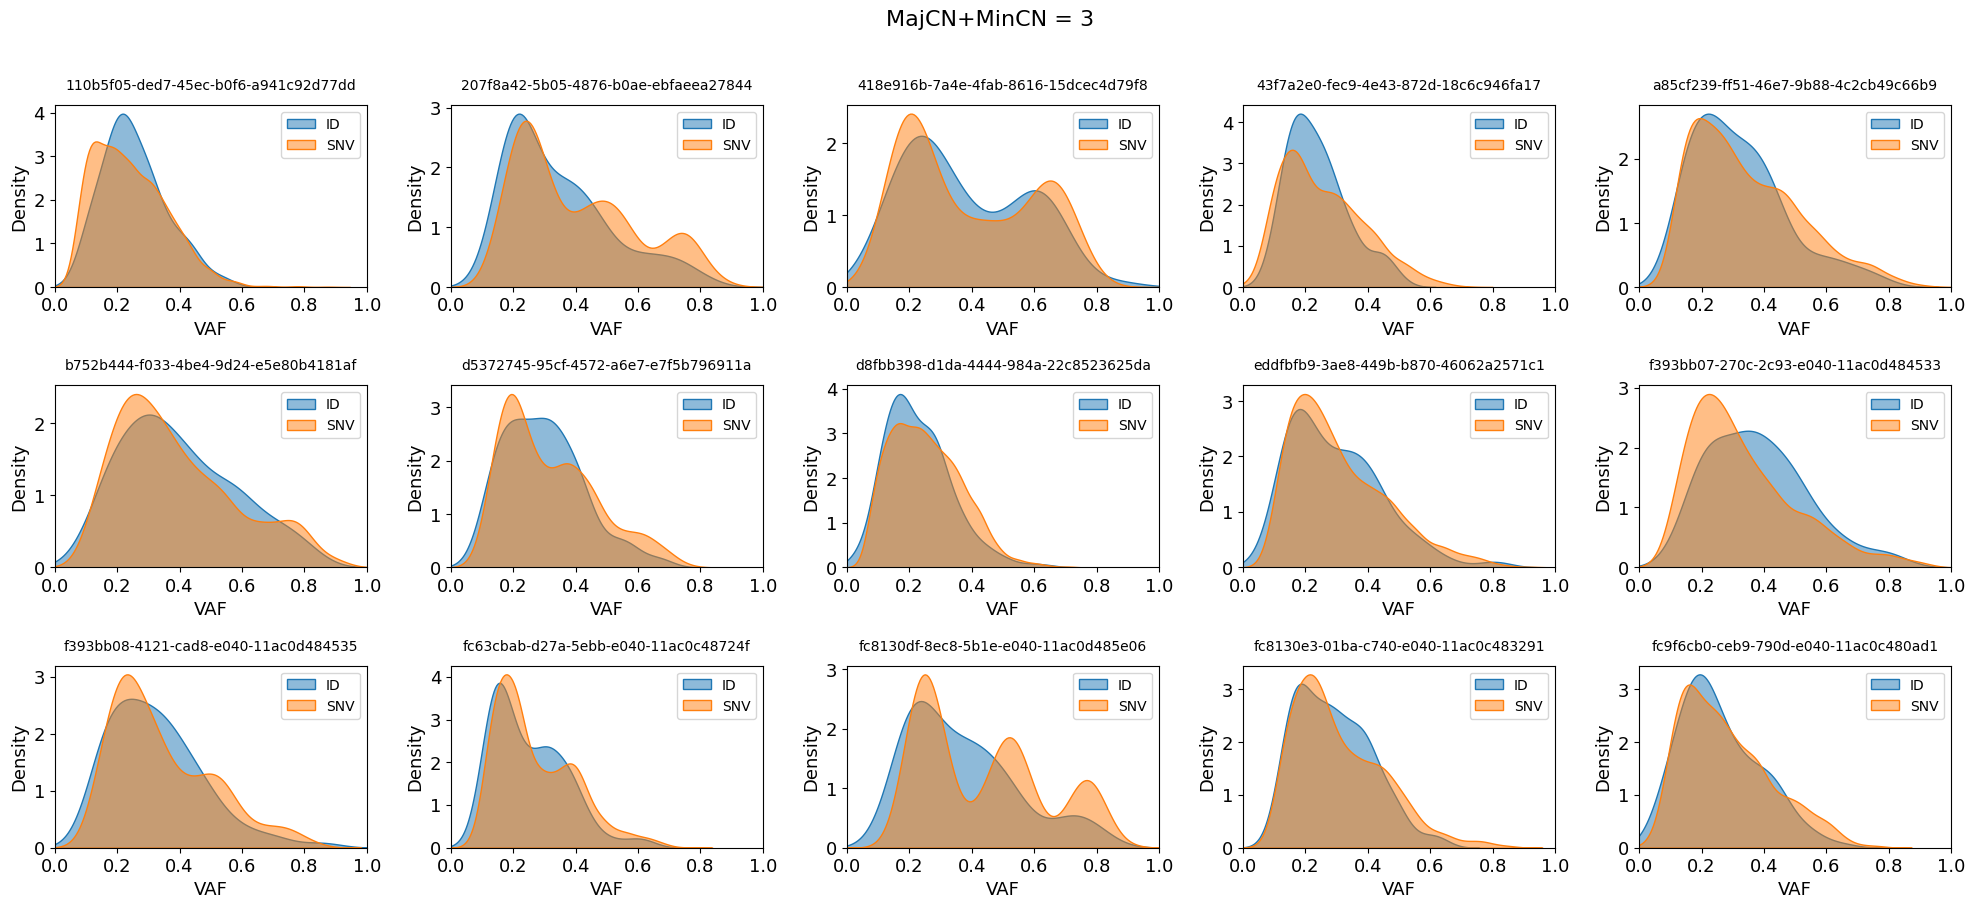

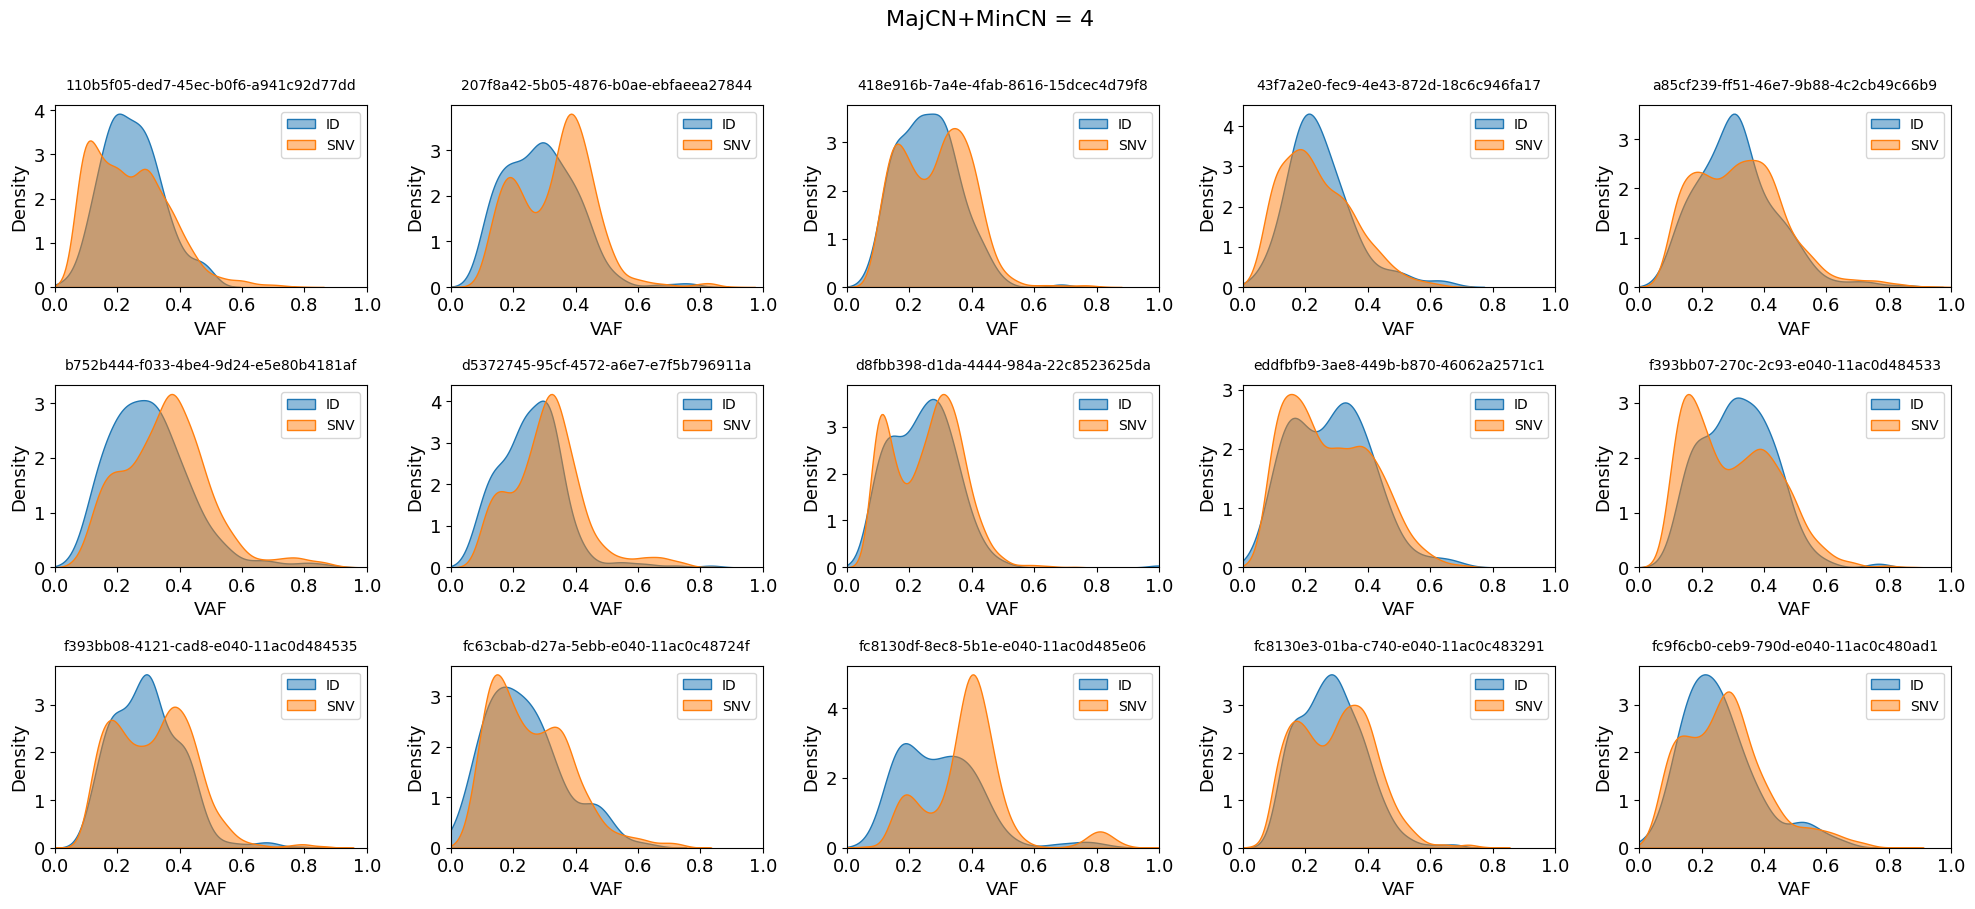

In [179]:
indel_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_indels"
snv_dir = "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/temp/PCAWG_HRD_WGD_Breast_clonal_SNVs"

def extract_vaf_and_total_cn(info):
    vaf_match = re.search(r'VAF=([\d.]+)', info)
    mincn_match = re.search(r'MinCN=(\d+)', info)
    majcn_match = re.search(r'MajCN=(\d+)', info)
    
    vaf = float(vaf_match.group(1)) if vaf_match else None
    mincn = int(mincn_match.group(1)) if mincn_match else None
    majcn = int(majcn_match.group(1)) if majcn_match else None
    
    total_cn = (mincn + majcn) if (mincn is not None and majcn is not None) else None
    return vaf, total_cn

def collect_data(folder):
    data = {2: {}, 3: {}, 4: {}}
    for file in os.listdir(folder):
        if file.endswith('.vcf'):
            df = pd.read_csv(os.path.join(folder, file), sep='\t')
            sample_id = file.replace('.vcf', '')
            
            vaf_cn_pairs = df['INFO'].apply(lambda x: extract_vaf_and_total_cn(x)).dropna().tolist()
            
            for total_cn in [2, 3, 4]:
                vafs_for_cn = [v for v, cn in vaf_cn_pairs if cn == total_cn and v is not None]
                if vafs_for_cn:
                    data[total_cn].setdefault(sample_id, []).extend(vafs_for_cn)
    return data

indel_data = collect_data(indel_dir)
snv_data = collect_data(snv_dir)

for total_cn in [2, 3, 4]:
    # Only keep samples of interest
    samples = sorted(
        (set(indel_data[total_cn]) | set(snv_data[total_cn]))
        & set(low_weighted_pi1_sbs3_samples)
    )
    n_samples = len(samples)
    
    if n_samples == 0:
        continue  # Skip if no relevant samples

    n_cols = 5
    n_rows = math.ceil(n_samples / n_cols)
    
    plt.rcParams.update({'font.size': 13, 'pdf.fonttype': 42})
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()
    
    for i, sample in enumerate(samples):
        ax = axes[i]
        if sample in indel_data[total_cn]:
            sns.kdeplot(indel_data[total_cn][sample], ax=ax, label='ID', color='tab:blue', fill=True, alpha=0.5)
        if sample in snv_data[total_cn]:
            sns.kdeplot(snv_data[total_cn][sample], ax=ax, label='SNV', color='tab:orange', fill=True, alpha=0.5)
        ax.set_title(f"{sample}", fontsize=10, y=1.04)
        ax.set_xlabel('VAF')
        ax.set_ylabel('Density')
        ax.legend(fontsize=10)
        ax.set_xlim(0, 1)
    
    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(f'MajCN+MinCN = {total_cn}', fontsize=16, y=1.01)
    plt.tight_layout()
    plt.show()

